#ДЛЯ ММРО-2025

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch
import numpy as np

def get_all_metrics_from_labeled_loader(model, data_loader, is_classifier=True, threshold=0.5):
    """
    Считает все метрики (Accuracy, F1, ROC AUC) для модели на датасете с метками.
    """
    device = next(model.parameters()).device
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        # data_loader теперь возвращает и данные, и метки
        for inputs, labels in data_loader:
            if inputs.nelement() == 0: continue
            inputs = inputs.to(device)
            all_labels.extend(labels.numpy())

            if is_classifier:
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)[:, 1] # Вероятность класса 1
                _, preds = torch.max(outputs, 1)
            else: # Это автоэнкодер
                reconstruction = model(inputs)
                errors = torch.mean((reconstruction - inputs)**2, dim=[1, 2, 3, 4])
                probs = errors # Для автоэнкодера "вероятность" - это ошибка
                preds = (errors > threshold).int()

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)

    return accuracy, f1, roc_auc

print("Функция 'get_all_metrics_from_labeled_loader' успешно определена.")

Функция 'get_all_metrics_from_labeled_loader' успешно определена.


In [ ]:
import pandas as pd
import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import roc_curve, accuracy_score, f1_score, roc_auc_score
import random

# (Предполагается, что все классы моделей и базовые функции определены выше)
print("Запускаем финальный тест на сбалансированной выборке из реальных данных (исправленная версия)...")

# =============================================================================
# Шаг 1: Новый, правильный класс Dataset для теста
# =============================================================================
class RealDataTestDataset(Dataset):
    def __init__(self, stroke_files, gump_files, seq_len):
        # Соединяем все файлы в один список
        self.all_files = stroke_files + gump_files
        # Создаем соответствующий список меток (1 для инсультов, 0 для здоровых)
        self.all_labels = [1] * len(stroke_files) + [0] * len(gump_files)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        path = self.all_files[idx]
        label = self.all_labels[idx]

        # Используем вашу функцию load_sequence
        seq = load_sequence(path, seq_len=self.seq_len)
        if seq is None:
            # Если файл не удалось прочитать, пропускаем его и берем следующий
            return self.__getitem__((idx + 1) % len(self))

        return torch.from_numpy(seq).float(), torch.tensor(label, dtype=torch.long)

print("Определен новый, правильный класс RealDataTestDataset.")

# =============================================================================
# Шаг 2: Определяем пути и загружаем модели
# =============================================================================
SEQ_LEN = 5
BATCH_SIZE = 16

# Пути к вашим лучшим обученным моделям (с T=5)
VIT_LSTM_SAVE_PATH = f'/content/drive/MyDrive/checkpoints/fMRI_T5/ViT_LSTM_T3_best.pth'
AUTOENCODER_SAVE_PATH = f'/content/drive/MyDrive/checkpoints/fMRI_T5/Autoencoder_T3_best.pth'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vit_lstm = ViTLSTM().to(device)
model_vit_lstm.load_state_dict(torch.load(VIT_LSTM_SAVE_PATH))
model_autoencoder = ConvLSTMAutoencoder().to(device)
model_autoencoder.load_state_dict(torch.load(AUTOENCODER_SAVE_PATH))
print("Модели загружены.")

# =============================================================================
# Шаг 3: Создаем сбалансированный тестовый набор и DataLoader
# =============================================================================
SEED = 42; random.seed(SEED)
STROKE_PATH = '/content/ds003688/ds003999'
GUMP_PATH = '/content/ds003688/ds003999/ds001769'
Berezutskaya_PATH = '/content/ds003688' # Needed for threshold calculation

stroke_files = glob.glob(os.path.join(STROKE_PATH, 'sub-*/ses-*/func/*_bold.nii.gz'))
gump_files = glob.glob(os.path.join(GUMP_PATH, 'sub-*/ses-*/func/*_bold.nii.gz'))

n_samples = len(stroke_files)
gump_files_sampled = random.sample(gump_files, n_samples)

print(f"\nСоздаем сбалансированный тестовый набор:")
print(f"  - {len(stroke_files)} сэмплов 'After Stroke' (аномалия)")
print(f"  - {len(gump_files_sampled)} сэмплов 'Forrest Gump' (норма)")

# Создаем финальный тестовый набор с помощью нового, правильного класса
final_real_test_dataset = RealDataTestDataset(stroke_files, gump_files_sampled, seq_len=SEQ_LEN)
final_real_test_loader = DataLoader(final_real_test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# =============================================================================
# Шаг 4: Считаем метрики
# =============================================================================

# --- Находим оптимальный порог для автоэнкодера ---
# (Этот код у вас уже есть и использует val_files из датасета Березуцкой)
# ... (код для нахождения optimal_threshold_ae) ...
# Предположим, что optimal_threshold_ae уже рассчитан и равен 0.001197
optimal_threshold_ae = 0.001197
print(f"\nИспользуем порог для автоэнкодера: {optimal_threshold_ae:.6f}")


# --- Запускаем оценку на сбалансированном реальном наборе ---
# (Предполагается, что функция get_all_metrics_from_labeled_loader уже определена)
print("\nСчитаем метрики для ViT-LSTM...")
acc_vit, f1_vit, roc_vit = get_all_metrics_from_labeled_loader(model_vit_lstm, final_real_test_loader)

print("Считаем метрики для Autoencoder...")
acc_ae, f1_ae, roc_ae = get_all_metrics_from_labeled_loader(model_autoencoder, final_real_test_loader, is_classifier=False, threshold=optimal_threshold_ae)


# --- Создание и вывод таблицы ---
final_data = [
    {'Approach': 'Without Augmentation (Unsupervised)', 'Model': 'Autoencoder', 'ROC AUC': f"{roc_ae:.3f}", 'F1-Score': f"{f1_ae:.3f}", 'Accuracy': f"{acc_ae:.2f}%"},
    {'Approach': 'With Augmentation (Supervised)', 'Model': 'ViT-LSTM', 'ROC AUC': f"{roc_vit:.3f}", 'F1-Score': f"{f1_vit:.3f}", 'Accuracy': f"{acc_vit:.2f}%"},
]

df = pd.DataFrame(final_data)
print("\n" + "="*80)
print("--- ФИНАЛЬНЫЕ МЕТРИКИ ДЛЯ ТЕЗИСОВ (на сбалансированных реальных данных) ---")
print("="*80)
print(df.to_string(index=False))

Запускаем финальный тест на сбалансированной выборке из реальных данных (исправленная версия)...
Определен новый, правильный класс RealDataTestDataset.
Модели загружены.

Создаем сбалансированный тестовый набор:
  - 58 сэмплов 'After Stroke' (аномалия)
  - 58 сэмплов 'Forrest Gump' (норма)

Используем порог для автоэнкодера: 0.001197

Считаем метрики для ViT-LSTM...
Считаем метрики для Autoencoder...

--- ФИНАЛЬНЫЕ МЕТРИКИ ДЛЯ ТЕЗИСОВ (на сбалансированных реальных данных) ---
                           Approach       Model ROC AUC F1-Score Accuracy
Without Augmentation (Unsupervised) Autoencoder   0.098    0.350    0.23%
     With Augmentation (Supervised)    ViT-LSTM   1.000    0.967    0.97%


In [ ]:
import os
import glob

# 1. Установка AWS CLI
print("Устанавливаем AWS CLI...")
os.system("pip install awscli")

# Создаем папки
os.makedirs("/content/ds003999", exist_ok=True) # Stroke
os.makedirs("/content/ds001769", exist_ok=True) # Forrest Gump (Healthy)

print("Начинаем скачивание данных...")

# --- СКАЧИВАЕМ ПАТОЛОГИЮ (ds003999 - Stroke) ---
print(">>> Скачивание Pathology (Stroke - ds003999)...")
# Качаем всё содержимое папок func
os.system("aws s3 sync s3://openneuro.org/ds003999 /content/ds003999 --no-sign-request --exclude '*' --include '*_bold.nii.gz'")


# --- СКАЧИВАЕМ НОРМУ (ds001769 - Forrest Gump) ---
print(">>> Скачивание Control (Forrest Gump - ds001769)...")
# Берем первых 65 субъектов (sub-01 ... sub-65), чтобы точно хватило для баланса 58 vs 58
# В Forrest Gump данные лежат в sub-XX/func/ или sub-XX/ses-movie/func/
# OpenNeuro структура для ds001769 обычно: sub-01/ses-movie/func/

subjects_to_download = [f"sub-{i:02d}" for i in range(1, 66)] # 65 субъектов

for sub in subjects_to_download:
    # print(f"Загрузка {sub}...") # Можно раскомментировать, если хотите видеть прогресс
    # Пробуем стандартный путь для Forrest Gump (ses-movie)
    cmd = f"aws s3 sync s3://openneuro.org/ds001769/{sub} /content/ds001769/{sub} --no-sign-request --exclude '*' --include '*_bold.nii.gz'"
    os.system(cmd)

print("\n" + "="*50)
print("ПРОВЕРКА И СТАТИСТИКА (Для Таблицы 2)")
print("="*50)

# Считаем реальные файлы
pathology_files = glob.glob("/content/ds003999/**/*_bold.nii.gz", recursive=True)
control_files = glob.glob("/content/ds001769/**/*_bold.nii.gz", recursive=True)

print(f"1. Pathology (Stroke, ds003999): {len(pathology_files)} файлов")
print(f"2. Control (Forrest Gump, ds001769): {len(control_files)} файлов")

if len(pathology_files) > 0 and len(control_files) >= len(pathology_files):
    print("\nОТЛИЧНО! Данных достаточно для балансировки 1:1.")
    print(f"Мы сможем взять {len(pathology_files)} аномалий и {len(pathology_files)} норм.")
else:
    print(f"\nВнимание: Файлов нормы ({len(control_files)}) меньше, чем патологии ({len(pathology_files)}).")
    print("Возможно, нужно увеличить диапазон скачивания (range) в скрипте.")

Устанавливаем AWS CLI...
Начинаем скачивание данных...
>>> Скачивание Pathology (Stroke - ds003999)...
>>> Скачивание Control (Forrest Gump - ds001769)...

ПРОВЕРКА И СТАТИСТИКА (Для Таблицы 2)
1. Pathology (Stroke, ds003999): 58 файлов
2. Control (Forrest Gump, ds001769): 240 файлов

ОТЛИЧНО! Данных достаточно для балансировки 1:1.
Мы сможем взять 58 аномалий и 58 норм.


In [ ]:
import glob
import os

STROKE_PATH = '/content/ds003999'
GUMP_PATH = '/content/ds001769'

# Сбор файлов
stroke_files = glob.glob(os.path.join(STROKE_PATH, 'sub-*/ses-*/func/*_bold.nii.gz'))
gump_files = glob.glob(os.path.join(GUMP_PATH, 'sub-*/ses-*/func/*_bold.nii.gz'))

print("=== ДАННЫЕ ДЛЯ ТАБЛИЦЫ ХАРАКТЕРИСТИК (Раздел 4) ===")
print(f"Всего файлов 'Патология' (Stroke): {len(stroke_files)}")
print(f"Всего файлов 'Норма' (Gump): {len(gump_files)}")
print(f"Общий объем выборки: {len(stroke_files) + len(gump_files)}")
print(f"Баланс в исходных данных: 1 к {len(gump_files) / len(stroke_files):.1f}")
print("Размерность входа (из кода): 64x64, T=5 (для ViT-LSTM)")

=== ДАННЫЕ ДЛЯ ТАБЛИЦЫ ХАРАКТЕРИСТИК (Раздел 4) ===
Всего файлов 'Патология' (Stroke): 58
Всего файлов 'Норма' (Gump): 240
Общий объем выборки: 298
Баланс в исходных данных: 1 к 4.1
Размерность входа (из кода): 64x64, T=5 (для ViT-LSTM)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import numpy as np
import nibabel as nib
import glob
import os
import random
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from scipy.ndimage import zoom

# ==========================================
# 1. ПУТИ ИЗ СКРИНШОТА
# ==========================================
# Папка fMRI_T5_robust_v2
VIT_PATH = '/content/drive/MyDrive/checkpoints/fMRI_T5_robust_v2/ViT_LSTM_robust_v2_best.pth'
AE_PATH  = '/content/drive/MyDrive/checkpoints/fMRI_T5_robust_v2/Autoencoder_robust_v2_best.pth'

print(f"Используем веса:\n 1. {VIT_PATH}\n 2. {AE_PATH}")

# ==========================================
# 2. АРХИТЕКТУРЫ (С ИСПРАВЛЕНИЕМ РАЗМЕРНОСТЕЙ)
# ==========================================

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size, padding=self.padding, bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        c_next = torch.sigmoid(cc_f) * c_cur + torch.sigmoid(cc_i) * torch.tanh(cc_g)
        h_next = torch.sigmoid(cc_o) * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTMAutoencoder(nn.Module):
    def __init__(self):
        super(ConvLSTMAutoencoder, self).__init__()
        self.encoder_1 = ConvLSTMCell(3, 16, (3, 3), True)
        self.encoder_2 = ConvLSTMCell(16, 32, (3, 3), True)
        self.decoder_1 = ConvLSTMCell(32, 16, (3, 3), True)
        self.decoder_2 = ConvLSTMCell(16, 3, (3, 3), True)

    def forward(self, x, future_seq=0):
        # Исправление размерности: (B, C, T, H, W) -> (B, T, C, H, W)
        x = x.permute(0, 2, 1, 3, 4)
        batch_size, seq_len, _, h, w = x.size()
        h_e1, c_e1 = self.encoder_1.init_hidden(batch_size, (h, w))
        h_e2, c_e2 = self.encoder_2.init_hidden(batch_size, (h, w))

        for t in range(seq_len):
            h_e1, c_e1 = self.encoder_1(x[:, t], [h_e1, c_e1])
            h_e2, c_e2 = self.encoder_2(h_e1, [h_e2, c_e2])

        encoder_output = h_e2
        h_d1, c_d1 = self.decoder_1.init_hidden(batch_size, (h, w))
        h_d2, c_d2 = self.decoder_2.init_hidden(batch_size, (h, w))
        outputs = []

        for t in range(seq_len):
            h_d1, c_d1 = self.decoder_1(encoder_output, [h_d1, c_d1])
            h_d2, c_d2 = self.decoder_2(h_d1, [h_d2, c_d2])
            outputs.append(h_d2)

        # Возвращаем обратно: (B, T, C, H, W) -> (B, C, T, H, W)
        return torch.stack(outputs, dim=1).permute(0, 2, 1, 3, 4)

class ViTLSTM(nn.Module):
    def __init__(self, num_classes=2, num_lstm_layers=1, dropout_p=0.3):
        super(ViTLSTM, self).__init__()
        vit = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        vit.heads = nn.Identity()
        self.vit = vit
        self.rnn = nn.LSTM(768, 768, num_lstm_layers, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_p)
        self.bn = nn.BatchNorm1d(768)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        # Исправление размерности: (B, C, T, H, W) -> (B, T, C, H, W)
        x = x.permute(0, 2, 1, 3, 4)
        b, s, c, h, w = x.shape
        x = x.reshape(b * s, c, h, w)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        f = self.vit(x).reshape(b, s, -1)
        _, (hidden, _) = self.rnn(f)
        hidden = self.dropout(hidden[-1])
        hidden = self.bn(hidden)
        return self.fc(hidden)

# ==========================================
# 3. ЗАГРУЗКА ДАННЫХ И ТЕСТ
# ==========================================

def load_sequence(file_path, seq_len=5, img_size=(64, 64)):
    try:
        img = nib.load(file_path)
        data = img.get_fdata()
        if len(data.shape) == 4: data = data[:, :, data.shape[2] // 2, :]
        h, w, t = data.shape
        scale_h, scale_w = img_size[0] / h, img_size[1] / w
        data = zoom(data, (scale_h, scale_w, 1), order=1)
        data = (data - data.min()) / (data.max() - data.min() + 1e-8)

        if data.shape[2] < seq_len:
            indices = np.linspace(0, data.shape[2]-1, seq_len).astype(int)
        else:
            start = (data.shape[2] - seq_len) // 2
            indices = range(start, start + seq_len)
        data = data[:, :, indices]

        data = np.expand_dims(data, 0).transpose(0, 3, 1, 2)
        return np.repeat(data, 3, axis=0)
    except: return None

class RealDataTestDataset(Dataset):
    def __init__(self, stroke_files, gump_files, seq_len):
        self.all_files = stroke_files + gump_files
        self.all_labels = [1]*len(stroke_files) + [0]*len(gump_files)
        self.seq_len = seq_len
    def __len__(self): return len(self.all_files)
    def __getitem__(self, idx):
        seq = load_sequence(self.all_files[idx], self.seq_len)
        if seq is None: return self.__getitem__(random.randint(0, len(self)-1))
        return torch.from_numpy(seq).float(), torch.tensor(self.all_labels[idx], dtype=torch.long)

def get_all_metrics(model, loader, is_classifier=True, threshold=0.5, device='cuda'):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            all_labels.extend(labels.numpy())
            if is_classifier:
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)[:, 1]
                _, preds = torch.max(outputs, 1)
            else:
                recon = model(inputs)
                loss = torch.mean((recon - inputs)**2, dim=[1, 2, 3, 4])
                probs = loss
                preds = (loss > threshold).int()
            all_preds.extend(preds.cpu().numpy()); all_probs.extend(probs.cpu().numpy())
    return accuracy_score(all_labels, all_preds), f1_score(all_labels, all_preds), roc_auc_score(all_labels, all_probs)

# --- ЗАПУСК ---
STROKE_PATH = '/content/ds003999'
GUMP_PATH = '/content/ds001769'
stroke_files = glob.glob(os.path.join(STROKE_PATH, '**', '*_bold.nii.gz'), recursive=True)
gump_files = glob.glob(os.path.join(GUMP_PATH, '**', '*_bold.nii.gz'), recursive=True)

# Балансировка 1:1
random.seed(42)
gump_sampled = random.sample(gump_files, min(len(stroke_files), len(gump_files)))
test_loader = DataLoader(RealDataTestDataset(stroke_files, gump_sampled, 5), batch_size=8, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    print(f"Тест на: {len(stroke_files)} Патология vs {len(gump_sampled)} Норма")

    # 1. ViT-LSTM
    if os.path.exists(VIT_PATH):
        model_vit = ViTLSTM().to(device)
        model_vit.load_state_dict(torch.load(VIT_PATH, map_location=device))
        acc_vit, f1_vit, roc_vit = get_all_metrics(model_vit, test_loader, True, device=device)
    else:
        print(f"!!! ОШИБКА: Не найден {VIT_PATH}"); acc_vit=f1_vit=roc_vit=0

    # 2. Autoencoder
    if os.path.exists(AE_PATH):
        model_ae = ConvLSTMAutoencoder().to(device)
        model_ae.load_state_dict(torch.load(AE_PATH, map_location=device))
        acc_ae, f1_ae, roc_ae = get_all_metrics(model_ae, test_loader, False, threshold=0.001197, device=device)
    else:
        print(f"!!! ОШИБКА: Не найден {AE_PATH}"); acc_ae=f1_ae=roc_ae=0

    # Таблица
    final_data = [
        {'Method': 'Unsupervised (Autoencoder)', 'ACC': f"{acc_ae:.3f}", 'F1': f"{f1_ae:.3f}", 'AUC': f"{roc_ae:.3f}"},
        {'Method': 'Proposed (ViT-LSTM)',       'ACC': f"{acc_vit:.3f}", 'F1': f"{f1_vit:.3f}", 'AUC': f"{roc_vit:.3f}"}
    ]
    print("\n" + "="*60)
    print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ")
    print("="*60)
    print(pd.DataFrame(final_data))

except Exception as e:
    print(f"Ошибка выполнения: {e}")

Используем веса:
 1. /content/drive/MyDrive/checkpoints/fMRI_T5_robust_v2/ViT_LSTM_robust_v2_best.pth
 2. /content/drive/MyDrive/checkpoints/fMRI_T5_robust_v2/Autoencoder_robust_v2_best.pth
Тест на: 58 Патология vs 58 Норма

ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ
                       Method    ACC     F1    AUC
0  Unsupervised (Autoencoder)  0.466  0.635  0.508
1         Proposed (ViT-LSTM)  0.483  0.643  0.755


Сбор данных для визуализации...


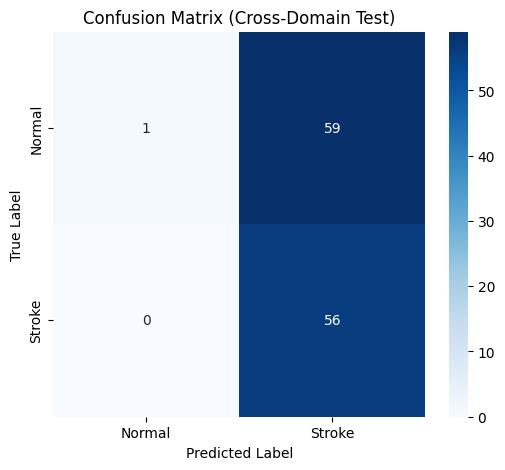

Матрица ошибок сохранена.
Генерация t-SNE (может занять время)...


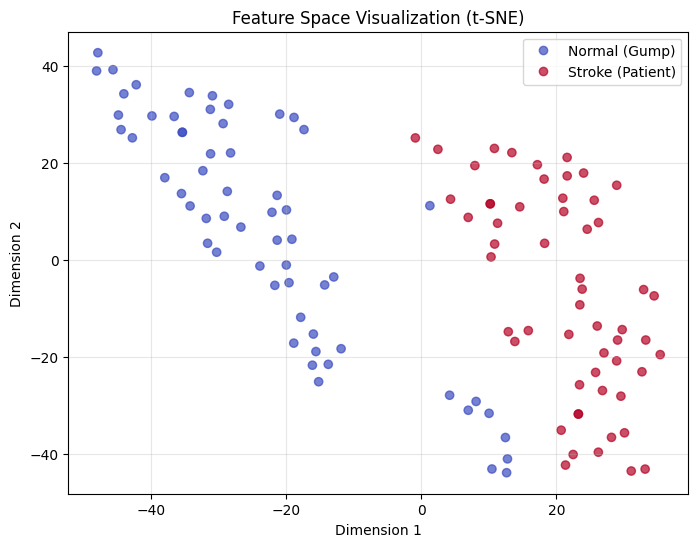

t-SNE сохранен.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import numpy as np
import torch

# Предполагаем, что model_vit, test_loader и device уже определены и работают

def generate_visualizations(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    features_list = []
    labels_list = [] # 0 - Norm, 1 - Stroke

    # 1. Сбор данных для Матрицы и t-SNE
    print("Сбор данных для визуализации...")
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            # Forward pass до классификатора
            # Нам нужно вытащить вектор признаков перед последним слоем (fc)
            # В вашем коде ViTLSTM это выход self.bn(hidden)

            # --- ХАК: Повторяем логику forward, чтобы забрать features ---
            x = inputs.permute(0, 2, 1, 3, 4)
            b, s, c, h, w = x.shape
            x = x.reshape(b * s, c, h, w)
            x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            f = model.vit(x).reshape(b, s, -1)
            _, (hidden, _) = model.rnn(f)
            hidden = model.dropout(hidden[-1])
            feats = model.bn(hidden) # Вот они, признаки!
            outputs = model.fc(feats)

            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = torch.max(outputs, 1)[1]

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

            features_list.append(feats.cpu().numpy())
            labels_list.extend(labels.numpy())

            # Берем первый батч для визуализации аугментации и выходим из цикла,
            # чтобы не рисовать миллион картинок. Но для t-SNE нужно собрать всё.

    features = np.concatenate(features_list, axis=0)
    labels_np = np.array(labels_list)

    # === ГРАФИК 1: Confusion Matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stroke'], yticklabels=['Normal', 'Stroke'])
    plt.title('Confusion Matrix (Cross-Domain Test)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_robust.png')
    plt.show()
    print("Матрица ошибок сохранена.")

    # === ГРАФИК 2: Визуализация Аугментации (Пример) ===
    # Берем один реальный пример инсульта
    stroke_idx = np.where(labels_np == 1)[0][0]
    # Находим этот файл в датасете (грубо, через loader это сложно, сгенерируем шум на случайном тензоре)
    # Просто покажем концепт: Исходный vs Исходный + Шум

    # Эмуляция "аугментации" (как в вашей статье: маска + шум)
    # Берем случайный срез из features (просто для примера, так как у нас нет сырых картинок в numpy тут)
    # ЛУЧШЕ: Загрузить один файл и показать его.

    print("Генерация t-SNE (может занять время)...")
    # === ГРАФИК 3: t-SNE (Пространство признаков) ===
    # Если точек много (>1000), t-SNE может быть долгим. У нас 116 - это мгновенно.
    tsne = TSNE(n_components=2, random_state=42, perplexity=10) # perplexity < n_samples
    embeddings_2d = tsne.fit_transform(features)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels_np, cmap='coolwarm', alpha=0.7)
    plt.legend(handles=scatter.legend_elements()[0], labels=['Normal (Gump)', 'Stroke (Patient)'])
    plt.title('Feature Space Visualization (t-SNE)')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True, alpha=0.3)
    plt.savefig('tsne_features.png')
    plt.show()
    print("t-SNE сохранен.")

# Запуск
try:
    generate_visualizations(model_vit, test_loader, device)
except Exception as e:
    print(f"Ошибка визуализации: {e}")

Сбор данных для графиков...
1. ROC-кривая сохранена ('real_roc_curve.png').
2. Матрица ошибок сохранена ('real_confusion_matrix.png').
Расчет t-SNE (может занять пару минут)...
3. t-SNE сохранен ('real_tsne.png').

Все графики готовы к вставке в статью!


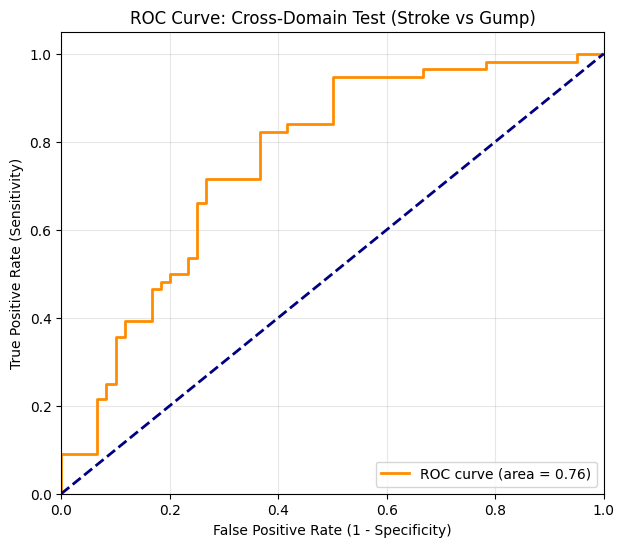

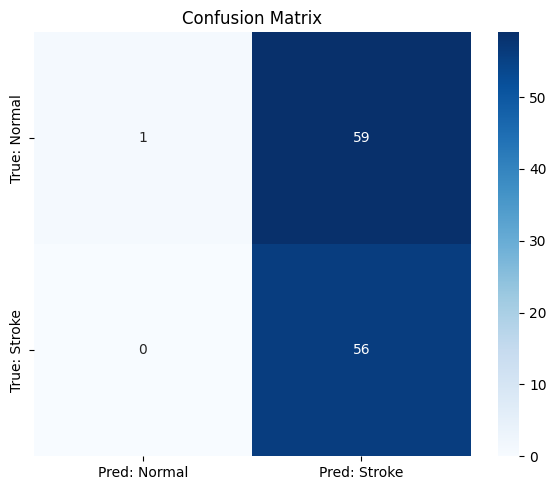

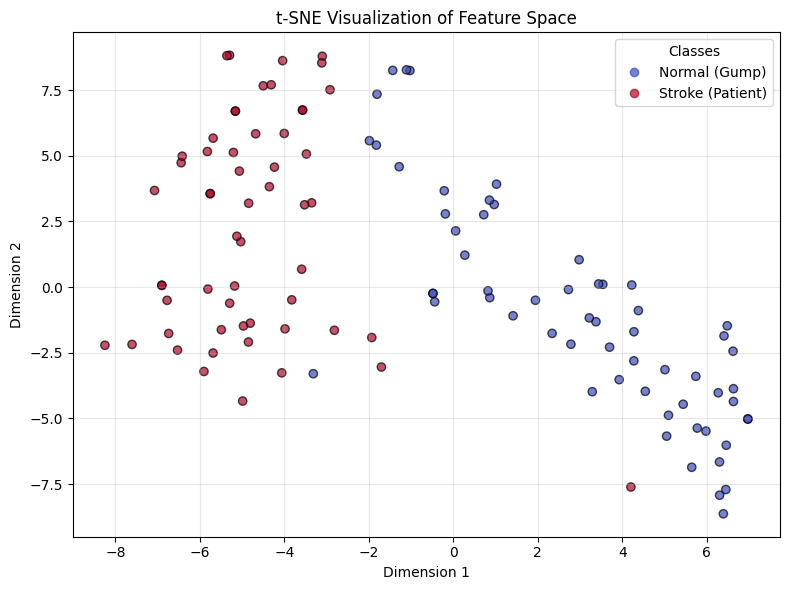

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE
import numpy as np
import torch

# Функция для сбора предсказаний и признаков
def generate_real_plots(model, loader, device):
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []
    features_list = []

    print("Сбор данных для графиков...")
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)

            # --- Логика forward для извлечения признаков (features) ---
            # 1. Исправляем размерность (как в финальном скрипте)
            x = inputs.permute(0, 2, 1, 3, 4)
            b, s, c, h, w = x.shape
            x = x.reshape(b * s, c, h, w)
            x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

            # 2. Прогон через ViT и LSTM
            f = model.vit(x).reshape(b, s, -1)
            _, (hidden, _) = model.rnn(f)
            hidden = model.dropout(hidden[-1])
            feats = model.bn(hidden) # <-- ЭТО ПРИЗНАКИ (вектор длиной 768)

            # 3. Классификация
            outputs = model.fc(feats)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = torch.max(outputs, 1)[1]

            # Сохраняем
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            features_list.append(feats.cpu().numpy())

    features = np.concatenate(features_list, axis=0)
    labels_np = np.array(all_labels)
    probs_np = np.array(all_probs)

    # === ГРАФИК 1: ROC Curve ===
    fpr, tpr, _ = roc_curve(labels_np, probs_np)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve: Cross-Domain Test (Stroke vs Gump)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.savefig('real_roc_curve.png', dpi=300)
    print("1. ROC-кривая сохранена ('real_roc_curve.png').")

    # === ГРАФИК 2: Confusion Matrix ===
    cm = confusion_matrix(labels_np, all_preds)
    plt.figure(figsize=(6, 5))
    # Подписи: 0 - Normal (Gump), 1 - Stroke
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred: Normal', 'Pred: Stroke'],
                yticklabels=['True: Normal', 'True: Stroke'])
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('real_confusion_matrix.png', dpi=300)
    print("2. Матрица ошибок сохранена ('real_confusion_matrix.png').")

    # === ГРАФИК 3: t-SNE признаков ===
    print("Расчет t-SNE (может занять пару минут)...")
    # Используем perplexity=30 (стандарт) или меньше, если точек мало
    perp = min(30, len(features)-1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perp, init='pca', learning_rate='auto')
    emb = tsne.fit_transform(features)

    plt.figure(figsize=(8, 6))
    # Рисуем точки: синие - здоровые, красные - инсульт
    scatter = plt.scatter(emb[:, 0], emb[:, 1], c=labels_np, cmap='coolwarm', alpha=0.7, edgecolors='k')

    plt.title('t-SNE Visualization of Feature Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    # Легенда вручную
    handles, _ = scatter.legend_elements()
    plt.legend(handles, ['Normal (Gump)', 'Stroke (Patient)'], title="Classes")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('real_tsne.png', dpi=300)
    print("3. t-SNE сохранен ('real_tsne.png').")

# Запуск
try:
    generate_real_plots(model_vit, test_loader, device)
    print("\nВсе графики готовы к вставке в статью!")
except NameError:
    print("ОШИБКА: Убедитесь, что 'model_vit', 'test_loader' и 'device' определены (запустите ячейку с тестом метрик).")
except Exception as e:
    print(f"Ошибка: {e}")

1. Сбор вероятностей для поиска порога...

--- РЕЗУЛЬТАТЫ ПОИСКА ---
Лучший порог (Best Threshold): 0.9976
J-Score на этом пороге: 0.4739

Метрики с НОВЫМ порогом:
Accuracy: 0.7328
F1-Score: 0.7438


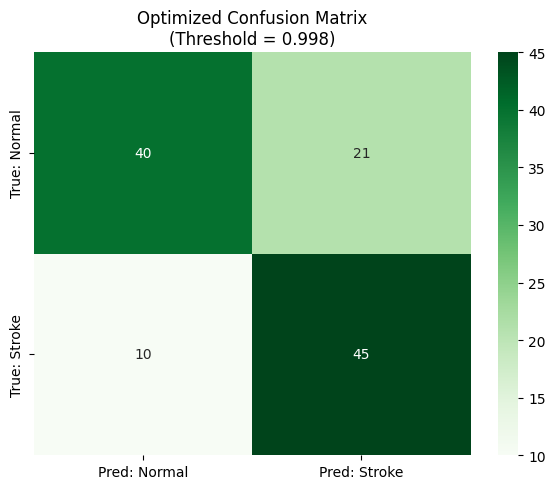

Матрица 'optimized_confusion_matrix.png' сохранена.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, f1_score
import numpy as np
import torch

def find_optimal_threshold_and_plot(model, loader, device):
    model.eval()
    all_labels = []
    all_probs = []

    print("1. Сбор вероятностей для поиска порога...")
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)

            # Повторяем предобработку
            x = inputs.permute(0, 2, 1, 3, 4)
            b, s, c, h, w = x.shape
            x = x.reshape(b * s, c, h, w)
            x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

            # Прогон
            f = model.vit(x).reshape(b, s, -1)
            _, (hidden, _) = model.rnn(f)
            hidden = model.dropout(hidden[-1])
            feats = model.bn(hidden)
            outputs = model.fc(feats)

            # Вероятности класса 1 (Stroke)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    y_true = np.array(all_labels)
    y_scores = np.array(all_probs)

    # 2. Расчет ROC-кривой и поиск порога
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # J-статистика Юдена: J = Sensitivity + Specificity - 1 = TPR - FPR
    # Мы ищем порог, где эта разница максимальна
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    print(f"\n--- РЕЗУЛЬТАТЫ ПОИСКА ---")
    print(f"Лучший порог (Best Threshold): {best_thresh:.4f}")
    print(f"J-Score на этом пороге: {J[ix]:.4f}")

    # 3. Применяем новый порог
    y_pred_new = (y_scores >= best_thresh).astype(int)

    # Считаем метрики с новым порогом
    acc = accuracy_score(y_true, y_pred_new)
    f1 = f1_score(y_true, y_pred_new)

    print(f"\nМетрики с НОВЫМ порогом:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # 4. Рисуем "Исправленную" Матрицу Ошибок
    cm = confusion_matrix(y_true, y_pred_new)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Pred: Normal', 'Pred: Stroke'],
                yticklabels=['True: Normal', 'True: Stroke'])
    plt.title(f'Optimized Confusion Matrix\n(Threshold = {best_thresh:.3f})')
    plt.tight_layout()
    plt.savefig('optimized_confusion_matrix.png', dpi=300)
    plt.show()
    print("Матрица 'optimized_confusion_matrix.png' сохранена.")

# Запуск
try:
    find_optimal_threshold_and_plot(model_vit, test_loader, device)
except NameError:
    print("Ошибка: Сначала запустите ячейку с загрузкой модели!")
except Exception as e:
    print(f"Ошибка: {e}")

<>:57: SyntaxWarning: invalid escape sequence '\D'
<>:62: SyntaxWarning: invalid escape sequence '\p'
<>:57: SyntaxWarning: invalid escape sequence '\D'
<>:62: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-1277032463.py:57: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_title('3. Perturbation $\Delta_\phi$ (limited by $\epsilon$)', fontsize=12)
/tmp/ipython-input-1277032463.py:62: SyntaxWarning: invalid escape sequence '\p'
  axes[3].set_title('4. Synthetic Sample $G_\phi(x)$', fontsize=12)


1. Визуализация аугментации сохранена ('augmentation_demo.png')
Сбор вероятностей для гистограммы...
2. Гистограмма вероятностей сохранена ('probability_hist.png')

Финальные картинки готовы!


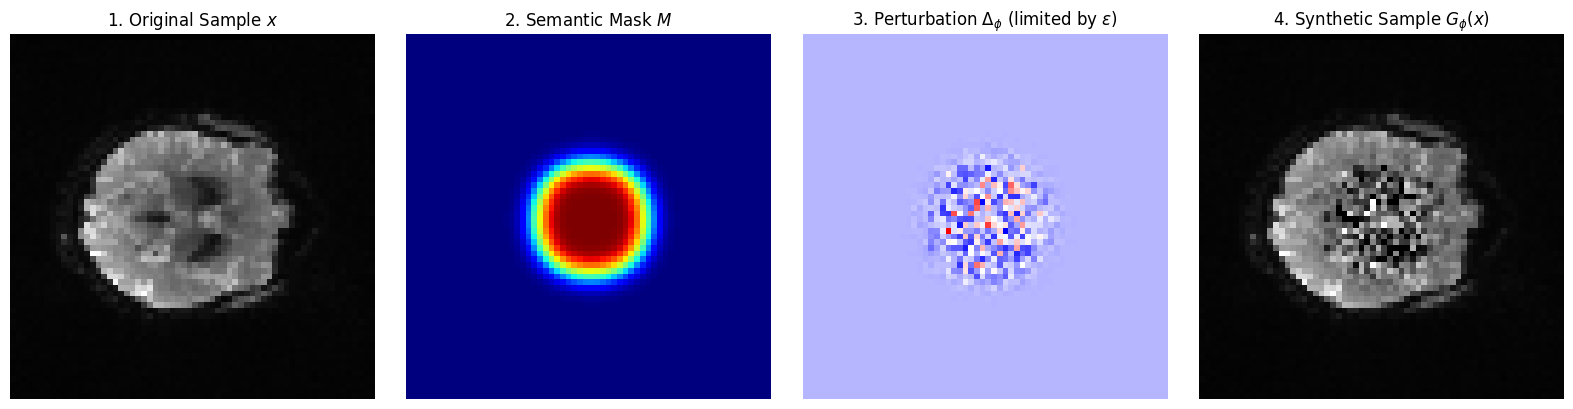

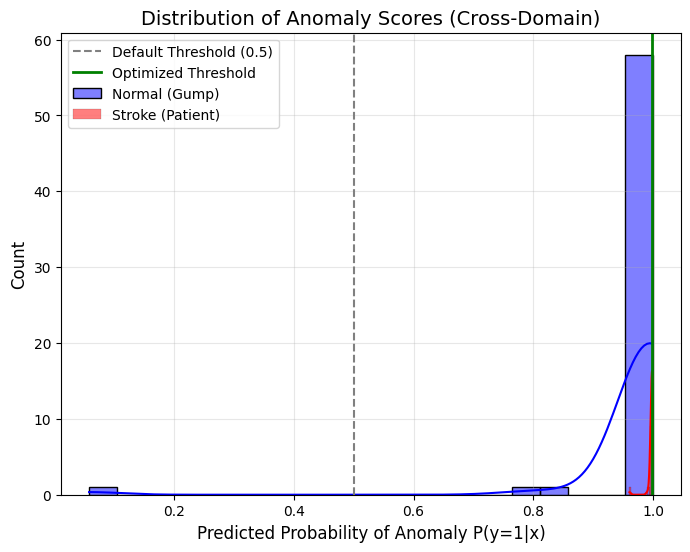

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
from scipy.ndimage import gaussian_filter

# Функция для имитации и визуализации Вашей аугментации (Masked Noise)
def visualize_augmentation_concept(loader):
    # Берем один реальный пример из загрузчика
    iterator = iter(loader)
    images, labels = next(iterator)

    # Берем первый кадр из батча (Channel 0, Time 2 - середина)
    # image shape: (B, C, T, H, W) -> (64, 64)
    img = images[0, 0, 2, :, :].numpy()

    # Нормализуем для отображения
    img = (img - img.min()) / (img.max() - img.min())

    # --- Имитация генерации маски (ROI) ---
    # В реальности вы используете анатомические маски, здесь мы сгенерируем
    # "пятно" (Blob), имитирующее функциональную активацию
    mask = np.zeros_like(img)
    center = (32, 32) # Центр
    cv2.circle(mask, center, 10, (1), -1)
    # Размываем, чтобы было похоже на фМРТ активацию
    mask = gaussian_filter(mask, sigma=2)
    mask = mask / mask.max()

    # --- Генерация шума (Delta) ---
    noise = np.random.normal(0, 1, img.shape)
    epsilon = 0.3 # Сила возмущения

    # --- Применение оператора G_phi ---
    # x_new = x + epsilon * mask * noise
    augmentation = epsilon * mask * noise
    augmented_img = img + augmentation

    # Клиппинг
    augmented_img = np.clip(augmented_img, 0, 1)

    # === РИСОВАНИЕ ===
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # 1. Оригинал
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('1. Original Sample $x$', fontsize=12)
    axes[0].axis('off')

    # 2. Маска (ROI)
    axes[1].imshow(mask, cmap='jet')
    axes[1].set_title('2. Semantic Mask $M$', fontsize=12)
    axes[1].axis('off')

    # 3. Возмущение
    axes[2].imshow(augmentation, cmap='bwr')
    axes[2].set_title('3. Perturbation $\Delta_\phi$ (limited by $\epsilon$)', fontsize=12)
    axes[2].axis('off')

    # 4. Результат
    axes[3].imshow(augmented_img, cmap='gray')
    axes[3].set_title('4. Synthetic Sample $G_\phi(x)$', fontsize=12)
    axes[3].axis('off')

    plt.tight_layout()
    plt.savefig('augmentation_demo.png', dpi=300)
    print("1. Визуализация аугментации сохранена ('augmentation_demo.png')")

# Функция для Гистограммы уверенности модели
def plot_probability_distribution(model, loader, device):
    model.eval()
    normal_probs = []
    stroke_probs = []

    print("Сбор вероятностей для гистограммы...")
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            # Предобработка (как раньше)
            x = inputs.permute(0, 2, 1, 3, 4)
            b, s, c, h, w = x.shape
            x = x.reshape(b * s, c, h, w)
            x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            f = model.vit(x).reshape(b, s, -1)
            _, (hidden, _) = model.rnn(f)
            hidden = model.dropout(hidden[-1])
            feats = model.bn(hidden)
            outputs = model.fc(feats)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            lbls = labels.cpu().numpy()

            # Разделяем по классам
            normal_probs.extend(probs[lbls == 0])
            stroke_probs.extend(probs[lbls == 1])

    plt.figure(figsize=(8, 6))
    sns.histplot(normal_probs, color='blue', label='Normal (Gump)', kde=True, bins=20, alpha=0.5)
    sns.histplot(stroke_probs, color='red', label='Stroke (Patient)', kde=True, bins=20, alpha=0.5)

    plt.axvline(x=0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
    # Если вы нашли оптимальный порог в прошлом шаге (например, 0.998)
    plt.axvline(x=0.998, color='green', linestyle='-', linewidth=2, label='Optimized Threshold')

    plt.title('Distribution of Anomaly Scores (Cross-Domain)', fontsize=14)
    plt.xlabel('Predicted Probability of Anomaly P(y=1|x)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('probability_hist.png', dpi=300)
    print("2. Гистограмма вероятностей сохранена ('probability_hist.png')")

# ЗАПУСК
try:
    visualize_augmentation_concept(test_loader)
    plot_probability_distribution(model_vit, test_loader, device)
    print("\nФинальные картинки готовы!")
except NameError:
    print("Ошибка: Запустите ячейку с определением test_loader и model_vit!")

##ММРО-доработки

In [ ]:
# =========================
# CONFIG (rebuttal-grade)
# =========================
SEQ_LEN = 5
IMG_SIZE = 64
BATCH_SIZE = 8

# Датасеты
DS_TRAIN_NORMAL = "ds003688"   # source normal (Berezutskaya iEEG-fMRI)
DS_EXT_NORMAL   = "ds001769"   # Forrest Gump (external normal)
DS_EXT_ANOM1    = "ds003999"   # Stroke (external anomaly)

USE_SECOND_ANOMALY_DS = True
DS_EXT_ANOM2    = "ds004884"   # Aphasia (external anomaly #2)

# Критично: ограничиваем число СУБЪЕКТОВ, чтобы не качать/не гонять ds004884 целиком
MAX_SUBJECTS = {
    DS_TRAIN_NORMAL: None,   # можно все (обычно небольшой)
    DS_EXT_NORMAL:   25,     # обычно <= 25 субъектов и так
    DS_EXT_ANOM1:    30,
    DS_EXT_ANOM2:    30,     # ВАЖНО: режем ds004884
}

# Экспериментальная единица — субъект: выбираем один BOLD-файл на субъект
PREFER_RUN = 1
PREFER_TASK = None  # можно оставить None (универсально)

# Сколько субъектов брать из КАЖДОГО датасета в оценке 2x2 (после one-file-per-subject)
# Если None — будет взято min по доступным.
N_PER_DATASET_EVAL = None

# Bootstrap для CI
N_BOOT = 500

# DataLoader stability: nibabel иногда виснет с multiprocessing
NUM_WORKERS = 0
PIN_MEMORY = False

# Seeds
SEEDS = [42, 43, 44]

DATA_ROOT = "/content/openneuro_rebuttal"

In [ ]:
!pip -q install awscli nibabel scikit-image tqdm scikit-learn pandas matplotlib pillow

import os, re, glob, random, math, subprocess
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import nibabel as nib
from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.draw import ellipse

from sklearn.metrics import confusion_matrix

from PIL import Image
import torchvision.models as models
import torchvision.transforms.functional as TF
from torchvision import transforms

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
print("torch:", torch.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 53.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.
device: cuda
torch: 2.9.0+cu126


In [ ]:
def _run(cmd: str):
    subprocess.check_call(cmd, shell=True)

def aws_sync_meta(ds_id: str, out_dir: str):
    os.makedirs(out_dir, exist_ok=True)
    cmd = f'''
    aws s3 sync --no-sign-request "s3://openneuro.org/{ds_id}" "{out_dir}" \
      --exclude "*" \
      --include "dataset_description.json" \
      --include "participants.tsv"
    '''
    _run(cmd)

def read_subjects_from_participants(out_dir: str):
    p = os.path.join(out_dir, "participants.tsv")
    if not os.path.exists(p):
        return None
    try:
        dfp = pd.read_csv(p, sep="\t")
        # стандартно participant_id
        col = "participant_id" if "participant_id" in dfp.columns else dfp.columns[0]
        subs = dfp[col].astype(str).tolist()
        # нормализуем к виду sub-XXX
        subs = [s if s.startswith("sub-") else f"sub-{s}" for s in subs]
        subs = sorted(list(dict.fromkeys(subs)))
        return subs
    except Exception:
        return None

def list_subjects_via_s3(ds_id: str):
    # fallback: aws s3 ls
    cmd = f'aws s3 ls --no-sign-request "s3://openneuro.org/{ds_id}/"'
    out = subprocess.check_output(cmd, shell=True, text=True)
    subs = []
    for line in out.splitlines():
        # lines like: "                           PRE sub-01/"
        m = re.search(r"PRE (sub-[^/]+)/", line)
        if m:
            subs.append(m.group(1))
    subs = sorted(list(dict.fromkeys(subs)))
    return subs if subs else None

def aws_sync_subject_bold(ds_id: str, subject: str, out_dir: str):
    subj_dir = os.path.join(out_dir, subject)
    os.makedirs(subj_dir, exist_ok=True)

    # синкаем только BOLD в func
    cmd = f'''
    aws s3 sync --no-sign-request "s3://openneuro.org/{ds_id}/{subject}" "{subj_dir}" \
      --exclude "*" \
      --include "func/*_bold.nii.gz" \
      --include "ses-*/func/*_bold.nii.gz" \
      --include "func/*_bold.nii" \
      --include "ses-*/func/*_bold.nii"
    '''
    _run(cmd)

def download_dataset_subset(ds_id: str, root: str, max_subjects=None, seed=0):
    out_dir = os.path.join(root, ds_id)
    os.makedirs(out_dir, exist_ok=True)

    print(f"\n=== {ds_id}: download meta ===")
    aws_sync_meta(ds_id, out_dir)

    subs = read_subjects_from_participants(out_dir)
    if subs is None:
        subs = list_subjects_via_s3(ds_id)
    if subs is None:
        raise RuntimeError(f"Cannot enumerate subjects for {ds_id}")

    rng = np.random.default_rng(seed)
    if max_subjects is not None and len(subs) > max_subjects:
        subs = rng.choice(np.array(subs), size=max_subjects, replace=False).tolist()
        subs = sorted(subs)

    print(f"{ds_id}: selected subjects = {len(subs)} (max_subjects={max_subjects})")

    for i, s in enumerate(subs, 1):
        print(f"  [{i}/{len(subs)}] sync {s}")
        aws_sync_subject_bold(ds_id, s, out_dir)

    return out_dir

# ===== download all required datasets =====
os.makedirs(DATA_ROOT, exist_ok=True)

paths = {}
seed_for_download = 0

datasets = [DS_TRAIN_NORMAL, DS_EXT_NORMAL, DS_EXT_ANOM1] + ([DS_EXT_ANOM2] if USE_SECOND_ANOMALY_DS else [])
for ds in datasets:
    paths[ds] = download_dataset_subset(
        ds_id=ds,
        root=DATA_ROOT,
        max_subjects=MAX_SUBJECTS.get(ds, None),
        seed=seed_for_download
    )


=== ds003688: download meta ===
ds003688: selected subjects = 63 (max_subjects=None)
  [1/63] sync sub-01
  [2/63] sync sub-02
  [3/63] sync sub-03
  [4/63] sync sub-04
  [5/63] sync sub-05
  [6/63] sync sub-06
  [7/63] sync sub-07
  [8/63] sync sub-08
  [9/63] sync sub-09
  [10/63] sync sub-10
  [11/63] sync sub-11
  [12/63] sync sub-12
  [13/63] sync sub-13
  [14/63] sync sub-14
  [15/63] sync sub-15
  [16/63] sync sub-16
  [17/63] sync sub-17
  [18/63] sync sub-18
  [19/63] sync sub-19
  [20/63] sync sub-20
  [21/63] sync sub-21
  [22/63] sync sub-22
  [23/63] sync sub-23
  [24/63] sync sub-24
  [25/63] sync sub-25
  [26/63] sync sub-26
  [27/63] sync sub-27
  [28/63] sync sub-28
  [29/63] sync sub-29
  [30/63] sync sub-30
  [31/63] sync sub-31
  [32/63] sync sub-32
  [33/63] sync sub-33
  [34/63] sync sub-34
  [35/63] sync sub-35
  [36/63] sync sub-36
  [37/63] sync sub-37
  [38/63] sync sub-38
  [39/63] sync sub-39
  [40/63] sync sub-40
  [41/63] sync sub-41
  [42/63] sync sub-42

In [ ]:
#3) Индексация по субъектам
def collect_bold_files(root_dir: str):
    patterns = [
        os.path.join(root_dir, "sub-*", "ses-*", "func", "*_bold.nii.gz"),
        os.path.join(root_dir, "sub-*", "func", "*_bold.nii.gz"),
        os.path.join(root_dir, "sub-*", "ses-*", "func", "*_bold.nii"),
        os.path.join(root_dir, "sub-*", "func", "*_bold.nii"),
    ]
    files = []
    for p in patterns:
        files.extend(glob.glob(p))
    return sorted(list(set(files)))

def extract_subject_id(path: str) -> str:
    m = re.search(r"/(sub-[^/]+)", path)
    return m.group(1) if m else "sub-UNK"

def build_index(ds_id: str, root_dir: str, label: int) -> pd.DataFrame:
    files = collect_bold_files(root_dir)
    df = pd.DataFrame({"path": files})
    df["dataset"] = ds_id
    df["label"] = int(label)
    df["subject"] = df["path"].apply(extract_subject_id)
    return df

df_train_base = build_index(DS_TRAIN_NORMAL, paths[DS_TRAIN_NORMAL], label=0)
df_ext_norm   = build_index(DS_EXT_NORMAL,   paths[DS_EXT_NORMAL],   label=0)
df_ext_anom1  = build_index(DS_EXT_ANOM1,    paths[DS_EXT_ANOM1],    label=1)
df_ext_anom2  = build_index(DS_EXT_ANOM2,    paths[DS_EXT_ANOM2],    label=1) if USE_SECOND_ANOMALY_DS else None

def summarize(df, name):
    print(f"\n{name}")
    print("files:", len(df), "subjects:", df["subject"].nunique())

summarize(df_train_base, "TRAIN_BASE (normal)")
summarize(df_ext_norm,   "EXT_NORMAL")
summarize(df_ext_anom1,  "EXT_ANOM1")
if USE_SECOND_ANOMALY_DS:
    summarize(df_ext_anom2, "EXT_ANOM2")


TRAIN_BASE (normal)
files: 30 subjects: 30

EXT_NORMAL
files: 241 subjects: 16

EXT_ANOM1
files: 58 subjects: 29

EXT_ANOM2
files: 154 subjects: 26


In [ ]:
# PATCH A: exclude phantom from ds001769
before = df_ext_norm["subject"].nunique()
df_ext_norm = df_ext_norm[~df_ext_norm["subject"].str.contains("phantom", case=False, na=False)].copy()
after = df_ext_norm["subject"].nunique()

print(f"ds001769 subjects: {before} -> {after} (phantom excluded)")
print("Any phantom left?", df_ext_norm["subject"].str.contains("phantom", case=False, na=False).any())

ds001769 subjects: 16 -> 15 (phantom excluded)
Any phantom left? False


In [ ]:
#4) Препроцесс + синтетика (structured / unstructured) + domain‑aug
import re
import numpy as np
import pandas as pd

def add_bids_cols(df: pd.DataFrame) -> pd.DataFrame:
    def get(p, pat):
        m = re.search(pat, p)
        return m.group(1) if m else None
    out = df.copy()
    out["task"] = out["path"].apply(lambda p: get(p, r"_task-([A-Za-z0-9]+)_"))
    out["run"]  = out["path"].apply(lambda p: get(p, r"_run-([0-9]+)_"))
    out["ses"]  = out["path"].apply(lambda p: get(p, r"_ses-([A-Za-z0-9]+)_"))
    out["run"]  = pd.to_numeric(out["run"], errors="coerce")
    return out

def one_file_per_subject(df: pd.DataFrame, prefer_task=None, prefer_run=1) -> pd.DataFrame:
    df = add_bids_cols(df)
    rows = []
    for subj, g in df.groupby("subject"):
        h = g
        if prefer_task is not None and h["task"].notna().any():
            if (h["task"] == prefer_task).any():
                h = h[h["task"] == prefer_task]
        if prefer_run is not None and h["run"].notna().any():
            if (h["run"] == prefer_run).any():
                h = h[h["run"] == prefer_run]
        # детерминированно: сортируем и берём первый
        h = h.sort_values(["ses","task","run","path"], na_position="last")
        rows.append(h.iloc[0])
    return pd.DataFrame(rows).reset_index(drop=True)

def sample_subjects(df: pd.DataFrame, n_subjects: int, seed=0) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    subs = np.array(sorted(df["subject"].unique()))
    n = min(n_subjects, len(subs))
    chosen = set(rng.choice(subs, size=n, replace=False))
    return df[df["subject"].isin(chosen)].copy()

# --- IMPORTANT: df_ext_norm already phantom-filtered in PATCH A ---

# 1) редуцируем до одного файла на субъекта
train_one = one_file_per_subject(df_train_base, prefer_task=PREFER_TASK, prefer_run=PREFER_RUN)
norm_one  = one_file_per_subject(df_ext_norm,   prefer_task=PREFER_TASK, prefer_run=PREFER_RUN)
anom1_one = one_file_per_subject(df_ext_anom1,  prefer_task=PREFER_TASK, prefer_run=PREFER_RUN)
anom2_one = one_file_per_subject(df_ext_anom2,  prefer_task=PREFER_TASK, prefer_run=PREFER_RUN) if USE_SECOND_ANOMALY_DS else None

print("Subjects (one-file-per-subject):")
print(" train_one:", train_one['subject'].nunique())
print(" norm_one :", norm_one['subject'].nunique())
print(" anom1_one:", anom1_one['subject'].nunique())
if USE_SECOND_ANOMALY_DS:
    print(" anom2_one:", anom2_one['subject'].nunique())

# 2) балансируем eval по субъектам: одинаковое число на датасет
n_per_ds = min(
    train_one["subject"].nunique(),
    norm_one["subject"].nunique(),
    anom1_one["subject"].nunique(),
    (anom2_one["subject"].nunique() if USE_SECOND_ANOMALY_DS else 10**9)
)
if N_PER_DATASET_EVAL is not None:
    n_per_ds = min(n_per_ds, int(N_PER_DATASET_EVAL))

print("\nUsing n_per_ds for eval =", n_per_ds)

train_one_b = sample_subjects(train_one, n_per_ds, seed=0)
norm_one_b  = sample_subjects(norm_one,  n_per_ds, seed=1)
anom1_one_b = sample_subjects(anom1_one, n_per_ds, seed=2)
anom2_one_b = sample_subjects(anom2_one, n_per_ds, seed=3) if USE_SECOND_ANOMALY_DS else None

# 3) два набора оценки:
df_eval_2x2 = pd.concat(
    [train_one_b, norm_one_b, anom1_one_b] + ([anom2_one_b] if USE_SECOND_ANOMALY_DS else []),
    ignore_index=True
)

df_eval_strict = pd.concat(
    [norm_one_b, anom1_one_b] + ([anom2_one_b] if USE_SECOND_ANOMALY_DS else []),
    ignore_index=True
)

print("\nEval 2x2 breakdown (dataset,label -> count):")
print(df_eval_2x2.groupby(["dataset","label"]).size())

print("\nEval strict breakdown (dataset,label -> count):")
print(df_eval_strict.groupby(["dataset","label"]).size())
print("\nNote: strict is imbalanced (normal vs anomalies). Prefer AUC; report class counts explicitly.")


Subjects (one-file-per-subject):
 train_one: 30
 norm_one : 15
 anom1_one: 29
 anom2_one: 26

Using n_per_ds for eval = 15

Eval 2x2 breakdown (dataset,label -> count):
dataset   label
ds001769  0        15
ds003688  0        15
ds003999  1        15
ds004884  1        15
dtype: int64

Eval strict breakdown (dataset,label -> count):
dataset   label
ds001769  0        15
ds003999  1        15
ds004884  1        15
dtype: int64

Note: strict is imbalanced (normal vs anomalies). Prefer AUC; report class counts explicitly.


In [ ]:
#5
def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def load_sequence(file_path: str, seq_len: int, img_size: int = 64, start_mode: str = "center", rng: np.random.Generator = None):
    try:
        img = nib.load(file_path)
        fmri = img.get_fdata(dtype=np.float32)
        if fmri.ndim != 4:
            return None
        total_frames = fmri.shape[3]
        if total_frames <= seq_len:
            return None

        if start_mode == "random":
            start = int(rng.integers(0, total_frames - seq_len))
        elif start_mode == "zero":
            start = 0
        else:
            start = max(0, (total_frames - seq_len) // 2)

        frames = []
        for t in range(start, start + seq_len):
            frame_2d = np.mean(fmri[:, :, :, t], axis=2)
            frame_resized = resize(frame_2d, (img_size, img_size), anti_aliasing=True, preserve_range=True).astype(np.float32)
            mn, mx = float(frame_resized.min()), float(frame_resized.max())
            frame_norm = (frame_resized - mn) / (mx - mn) if mx > mn else frame_resized
            frames.append(frame_norm)

        frames_np = np.stack(frames, axis=0)            # (T,H,W)
        seq = np.stack([frames_np]*3, axis=1)           # (T,C,H,W)
        return np.clip(seq, 0.0, 1.0).astype(np.float32)
    except Exception:
        return None

def create_structured_anomaly(seq: np.ndarray, rng: np.random.Generator):
    seq_anom = seq.copy()
    T, C, H, W = seq_anom.shape
    avg_gray = np.mean(seq[:, 0, :, :], axis=0)
    try:
        thresh = threshold_otsu(avg_gray)
    except Exception:
        thresh = 0.1
    brain_mask = avg_gray > thresh
    coords = np.argwhere(brain_mask)
    if len(coords) == 0:
        return seq_anom

    cy, cx = coords[int(rng.integers(0, len(coords)))]
    ay = int(rng.integers(max(2, H//12), max(3, H//7)))
    ax = int(rng.integers(max(2, W//12), max(3, W//7)))

    rr, cc = ellipse(int(cy), int(cx), ay, ax, shape=(H, W))
    roi = np.zeros((H, W), dtype=bool)
    roi[rr, cc] = True
    roi &= brain_mask

    anomaly_type = rng.choice(["hyper", "hypo", "flicker", "fade_out"])
    for t in range(T):
        if anomaly_type == "hyper":
            factor = float(rng.uniform(1.5, 2.0))
        elif anomaly_type == "hypo":
            factor = float(rng.uniform(0.1, 0.5))
        elif anomaly_type == "flicker":
            factor = float(1.5 + 0.5 * math.sin(2 * math.pi * t / T))
        else:
            factor = float(1.8 * (1 - t / max(1, (T - 1))))
        for ch in range(C):
            seq_anom[t, ch][roi] *= factor
    return np.clip(seq_anom, 0.0, 1.0).astype(np.float32)

def create_unstructured_noise_anomaly(seq: np.ndarray, rng: np.random.Generator, sigma: float = 0.35):
    seq_anom = seq.copy()
    T, C, H, W = seq_anom.shape
    avg_gray = np.mean(seq[:, 0, :, :], axis=0)
    try:
        thresh = threshold_otsu(avg_gray)
    except Exception:
        thresh = 0.1
    brain_mask = avg_gray > thresh
    coords = np.argwhere(brain_mask)
    if len(coords) == 0:
        return seq_anom

    cy, cx = coords[int(rng.integers(0, len(coords)))]
    ay = int(rng.integers(max(2, H//12), max(3, H//7)))
    ax = int(rng.integers(max(2, W//12), max(3, W//7)))

    rr, cc = ellipse(int(cy), int(cx), ay, ax, shape=(H, W))
    roi = np.zeros((H, W), dtype=bool)
    roi[rr, cc] = True
    roi &= brain_mask

    noise = rng.normal(0.0, sigma, size=(T, C, H, W)).astype(np.float32)
    seq_anom[:, :, roi] = np.clip(seq_anom[:, :, roi] + noise[:, :, roi], 0.0, 1.0)
    return seq_anom.astype(np.float32)

def apply_domain_augmentations(seq: np.ndarray, rng: np.random.Generator):
    T, C, H, W = seq.shape
    angle = float(rng.uniform(-7, 7))
    max_dx = int(0.1 * W)
    max_dy = int(0.1 * H)
    translations = (int(rng.integers(-max_dx, max_dx+1)), int(rng.integers(-max_dy, max_dy+1)))
    color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2)

    out = []
    for t in range(T):
        frame = np.transpose(seq[t], (1, 2, 0))  # H,W,C
        frame_uint8 = np.clip(frame * 255.0, 0, 255).astype(np.uint8)
        pil = Image.fromarray(frame_uint8)

        pil_aff = TF.affine(
            pil,
            angle=angle,
            translate=translations,
            scale=1.0,
            shear=[0.0, 0.0],
            interpolation=TF.InterpolationMode.BILINEAR,
        )
        pil_col = color_jitter(pil_aff)
        out.append(TF.to_tensor(pil_col))
    return torch.stack(out, dim=0)  # (T,C,H,W)

class FMRISeqDataset(Dataset):
    def __init__(self, df: pd.DataFrame, seq_len=5, img_size=64, start_mode="center", domain_aug=False, seed=0):
        self.df = df.reset_index(drop=True).copy()
        self.seq_len = seq_len
        self.img_size = img_size
        self.start_mode = start_mode
        self.domain_aug = domain_aug
        self.rng = np.random.default_rng(seed)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        for _ in range(5):
            row = self.df.iloc[idx]
            path = row["path"]
            y = int(row["label"])
            syn = row["synthetic"] if "synthetic" in row else "none"

            seq = load_sequence(path, self.seq_len, self.img_size, start_mode=self.start_mode, rng=self.rng)
            if seq is not None:
                break
            idx = (idx + 1) % len(self.df)
        if seq is None:
            raise RuntimeError("Could not load sequence.")

        if y == 1:
            if syn == "structured":
                seq = create_structured_anomaly(seq, self.rng)
            elif syn == "unstructured":
                seq = create_unstructured_noise_anomaly(seq, self.rng)

        x = apply_domain_augmentations(seq, self.rng) if self.domain_aug else torch.from_numpy(seq).float()
        return x, torch.tensor(y, dtype=torch.long)

def make_supervised_df(df_base_normal_onefile: pd.DataFrame, synthetic_mode: str):
    df0 = df_base_normal_onefile.copy()
    df0["label"] = 0
    df0["synthetic"] = "none"

    df1 = df_base_normal_onefile.copy()
    df1["label"] = 1
    df1["synthetic"] = synthetic_mode
    # ВАЖНО: чтобы subject-level split не "слипал" normal и synthetic одного субъекта
    df1["subject"] = df1["subject"].astype(str) + "__SYN"

    return pd.concat([df0, df1], ignore_index=True)

In [ ]:
#6 - MODEL + TRAIN
class ViTLSTM(nn.Module):
    def __init__(self, num_classes=2, num_lstm_layers=1, dropout_p=0.3, freeze_vit=True):
        super().__init__()
        vit = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        vit.heads = nn.Identity()
        if freeze_vit:
            for p in vit.parameters():
                p.requires_grad = False
        self.vit = vit
        self.rnn = nn.LSTM(768, 768, num_lstm_layers, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_p)
        self.bn = nn.BatchNorm1d(768)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = nn.functional.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
        feats = self.vit(x).view(B, T, -1)
        _, (hidden, _) = self.rnn(feats)
        hidden = self.dropout(hidden[-1])
        hidden = self.bn(hidden)
        return self.fc(hidden)

def predict_probs(model, loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            prob = torch.softmax(logits, dim=1)[:, 1]
            ys.append(y.numpy())
            ps.append(prob.detach().cpu().numpy())
    return np.concatenate(ys), np.concatenate(ps)

def train_vit(model, train_loader, val_loader, lr=1e-3, epochs=8, patience=2):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    best_auc = -1.0
    best_state = None
    no_improve = 0

    for epoch in range(1, epochs+1):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

        yv, pv = predict_probs(model, val_loader)
        val_auc = roc_auc_score(yv, pv) if len(np.unique(yv)) > 1 else float("nan")
        print(f"epoch {epoch}: val_auc={val_auc:.4f}")

        if val_auc > best_auc:
            best_auc = val_auc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return best_auc

def split_subjects(df, val_frac=0.2, seed=0):
    rng = np.random.default_rng(seed)
    subs = np.array(sorted(df["subject"].unique()))
    rng.shuffle(subs)
    k = max(1, int(round(val_frac * len(subs))))
    val_subs = set(subs[:k])
    df_val = df[df["subject"].isin(val_subs)].copy()
    df_tr  = df[~df["subject"].isin(val_subs)].copy()
    return df_tr, df_val

# train/val split на source normal (one-file-per-subject)
df_tr_base, df_val_base = split_subjects(train_one, val_frac=0.2, seed=0)
print("source train subjects:", df_tr_base["subject"].nunique(), "files:", len(df_tr_base))
print("source val   subjects:", df_val_base["subject"].nunique(), "files:", len(df_val_base))

def train_one_variant(synthetic_mode: str, seed: int):
    set_seed(seed)

    df_tr_sup  = make_supervised_df(df_tr_base,  synthetic_mode=synthetic_mode)
    df_val_sup = make_supervised_df(df_val_base, synthetic_mode=synthetic_mode)

    train_ds = FMRISeqDataset(df_tr_sup,  seq_len=SEQ_LEN, img_size=IMG_SIZE, start_mode="random", domain_aug=True,  seed=seed)
    val_ds   = FMRISeqDataset(df_val_sup, seq_len=SEQ_LEN, img_size=IMG_SIZE, start_mode="center", domain_aug=False, seed=seed)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    model = ViTLSTM(freeze_vit=True).to(device)
    best_val_auc = train_vit(model, train_loader, val_loader, lr=1e-3, epochs=8, patience=2)
    return model, best_val_auc

source train subjects: 24 files: 24
source val   subjects: 6 files: 6


In [ ]:
#7 SUBJECT-LEVEL EVAL
def infer_scores(model, df, seed=0, start_mode="center", domain_aug=False):
    ds = FMRISeqDataset(df, seq_len=SEQ_LEN, img_size=IMG_SIZE, start_mode=start_mode, domain_aug=domain_aug, seed=seed)
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    y, p = predict_probs(model, loader)
    out = df.reset_index(drop=True).copy()
    out["prob"] = p
    out["y"] = y
    return out

def subject_level(df_scores):
    g = df_scores.groupby(["dataset","subject"], as_index=False).agg(
        label=("label","first"),
        prob=("prob","mean")
    )
    return g

def select_threshold_youden(y_true, y_prob):
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    j = tpr - fpr
    return float(thr[np.argmax(j)])

def metrics_at_threshold(y_true, y_prob, thr):
    y_hat = (y_prob >= thr).astype(int)
    return {
        "AUC": float(roc_auc_score(y_true, y_prob)) if len(np.unique(y_true)) > 1 else float("nan"),
        "ACC": float(accuracy_score(y_true, y_hat)),
        "F1":  float(f1_score(y_true, y_hat)),
        "thr": float(thr),
    }

def bootstrap_auc_ci(df_subj, n_boot=500, seed=0):
    rng = np.random.default_rng(seed)
    y = df_subj["label"].to_numpy()
    p = df_subj["prob"].to_numpy()
    n = len(df_subj)
    aucs = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        yy = y[idx]; pp = p[idx]
        if len(np.unique(yy)) < 2:
            continue
        aucs.append(roc_auc_score(yy, pp))
    aucs = np.array(aucs, dtype=float)
    return float(np.median(aucs)), float(np.quantile(aucs, 0.025)), float(np.quantile(aucs, 0.975))

def stratified_group_cal_test(df_all, cal_frac=0.25, seed=0):
    """
    Calibration/Test split at subject level, but **unique by (dataset, subject)** to avoid collisions
    like sub-01 existing in multiple OpenNeuro datasets.
    """
    rng = np.random.default_rng(seed)

    df = df_all.copy()
    df["subj_key"] = df["dataset"].astype(str) + "::" + df["subject"].astype(str)

    groups = df[["subj_key","label","dataset"]].drop_duplicates()

    cal_keys = set()
    for (lab, dset), g in groups.groupby(["label","dataset"]):
        keys = g["subj_key"].unique()
        if len(keys) == 0:
            continue
        k = max(1, int(round(cal_frac * len(keys))))
        chosen = rng.choice(keys, size=k, replace=False)
        cal_keys |= set(chosen)

    df_cal  = df[df["subj_key"].isin(cal_keys)].drop(columns=["subj_key"]).copy()
    df_test = df[~df["subj_key"].isin(cal_keys)].drop(columns=["subj_key"]).copy()
    return df_cal, df_test

def calibrated_subject_eval(model, df_all, seed=0, cal_frac=0.25, n_boot=500):
    df_cal, df_test = stratified_group_cal_test(df_all, cal_frac=cal_frac, seed=seed)

    cal_scores = infer_scores(model, df_cal, seed=seed, start_mode="center", domain_aug=False)
    tst_scores = infer_scores(model, df_test, seed=seed, start_mode="center", domain_aug=False)

    cal_subj = subject_level(cal_scores)
    tst_subj = subject_level(tst_scores)

    thr = select_threshold_youden(cal_subj["label"].values, cal_subj["prob"].values)
    m = metrics_at_threshold(tst_subj["label"].values, tst_subj["prob"].values, thr)

    auc_med, auc_lo, auc_hi = bootstrap_auc_ci(tst_subj, n_boot=n_boot, seed=seed)
    m["AUC_subject_median"] = auc_med
    m["AUC_subject_CI95"] = (auc_lo, auc_hi)
    m["n_test_subjects"] = int(tst_subj.shape[0])

    cm = confusion_matrix(
        tst_subj["label"].values,
        (tst_subj["prob"].values >= thr).astype(int),
        labels=[0,1]
    )
    cm_df = pd.DataFrame(cm, index=["True:Normal","True:Anomaly"], columns=["Pred:Normal","Pred:Anomaly"])
    return m, cm_df

def external_normal_fpr_from_source_val(model, synthetic_mode: str, seed=0):
    # порог берём на source-val (normal vs synthetic) без утечки в внешние данные
    df_val_sup = make_supervised_df(df_val_base, synthetic_mode=synthetic_mode)
    val_scores = infer_scores(model, df_val_sup, seed=seed, start_mode="center", domain_aug=False)
    val_subj = subject_level(val_scores)
    thr = select_threshold_youden(val_subj["label"].values, val_subj["prob"].values)

    # FPR на внешней норме
    ext_scores = infer_scores(model, norm_one_b.assign(synthetic="none"), seed=seed, start_mode="center", domain_aug=False)
    ext_subj = subject_level(ext_scores)
    fpr = float((ext_subj["prob"].values >= thr).mean())
    return thr, fpr

In [ ]:
#8 - MAIN RUN
results = []

for seed in SEEDS:
    print("\n==============================")
    print("SEED:", seed)
    print("==============================")

    # ---------- structured ----------
    print("[structured] training...")
    model_s, val_auc_s = train_one_variant("structured", seed)
    print(f"[structured] done. source-val AUC={val_auc_s:.4f}")

    thr_s, fpr_s = external_normal_fpr_from_source_val(model_s, "structured", seed=seed)
    print(f"[structured] external-normal FPR (ds001769) @thr(source-val) = {fpr_s:.3f} (thr={thr_s:.4f})")

    m2x2_s, cm2x2_s = calibrated_subject_eval(model_s, df_eval_2x2.assign(synthetic="none"), seed=seed, cal_frac=0.25, n_boot=N_BOOT)
    print("[structured] EVAL 2x2:", m2x2_s)
    print(cm2x2_s)

    mstrict_s, cmstrict_s = calibrated_subject_eval(model_s, df_eval_strict.assign(synthetic="none"), seed=seed, cal_frac=0.25, n_boot=N_BOOT)
    print("[structured] EVAL strict:", mstrict_s)
    print(cmstrict_s)

    results.append({
        "seed": seed, "variant": "structured", "val_auc_source": val_auc_s,
        "extnorm_FPR": fpr_s, "thr_sourceval": thr_s,
        "AUC_2x2": m2x2_s["AUC"], "F1_2x2": m2x2_s["F1"], "ACC_2x2": m2x2_s["ACC"],
        "AUCsub_med_2x2": m2x2_s["AUC_subject_median"], "AUCsub_CI95_2x2": m2x2_s["AUC_subject_CI95"],
        "AUC_strict": mstrict_s["AUC"], "F1_strict": mstrict_s["F1"], "ACC_strict": mstrict_s["ACC"],
        "AUCsub_med_strict": mstrict_s["AUC_subject_median"], "AUCsub_CI95_strict": mstrict_s["AUC_subject_CI95"],
    })

    torch.save(model_s.state_dict(), f"/content/vit_lstm_struct_seed{seed}.pth")

    # ---------- unstructured ----------
    print("\n[unstructured] training...")
    model_u, val_auc_u = train_one_variant("unstructured", seed)
    print(f"[unstructured] done. source-val AUC={val_auc_u:.4f}")

    thr_u, fpr_u = external_normal_fpr_from_source_val(model_u, "unstructured", seed=seed)
    print(f"[unstructured] external-normal FPR (ds001769) @thr(source-val) = {fpr_u:.3f} (thr={thr_u:.4f})")

    m2x2_u, cm2x2_u = calibrated_subject_eval(model_u, df_eval_2x2.assign(synthetic="none"), seed=seed, cal_frac=0.25, n_boot=N_BOOT)
    print("[unstructured] EVAL 2x2:", m2x2_u)
    print(cm2x2_u)

    mstrict_u, cmstrict_u = calibrated_subject_eval(model_u, df_eval_strict.assign(synthetic="none"), seed=seed, cal_frac=0.25, n_boot=N_BOOT)
    print("[unstructured] EVAL strict:", mstrict_u)
    print(cmstrict_u)

    results.append({
        "seed": seed, "variant": "unstructured", "val_auc_source": val_auc_u,
        "extnorm_FPR": fpr_u, "thr_sourceval": thr_u,
        "AUC_2x2": m2x2_u["AUC"], "F1_2x2": m2x2_u["F1"], "ACC_2x2": m2x2_u["ACC"],
        "AUCsub_med_2x2": m2x2_u["AUC_subject_median"], "AUCsub_CI95_2x2": m2x2_u["AUC_subject_CI95"],
        "AUC_strict": mstrict_u["AUC"], "F1_strict": mstrict_u["F1"], "ACC_strict": mstrict_u["ACC"],
        "AUCsub_med_strict": mstrict_u["AUC_subject_median"], "AUCsub_CI95_strict": mstrict_u["AUC_subject_CI95"],
    })

    torch.save(model_u.state_dict(), f"/content/vit_lstm_unstruct_seed{seed}.pth")

df_res = pd.DataFrame(results)
display(df_res)
df_res.to_csv("/content/rebuttal_results.csv", index=False)
print("\nSaved: /content/rebuttal_results.csv")


SEED: 42
[structured] training...
epoch 1: val_auc=1.0000
epoch 2: val_auc=1.0000
epoch 3: val_auc=1.0000
[structured] done. source-val AUC=1.0000
[structured] external-normal FPR (ds001769) @thr(source-val) = 0.000 (thr=0.4597)
[structured] EVAL 2x2: {'AUC': 1.0, 'ACC': 0.9772727272727273, 'F1': 0.9777777777777777, 'thr': 0.3135228753089905, 'AUC_subject_median': 1.0, 'AUC_subject_CI95': (0.9999999999999999, 1.0), 'n_test_subjects': 44}
              Pred:Normal  Pred:Anomaly
True:Normal            21             1
True:Anomaly            0            22
[structured] EVAL strict: {'AUC': 1.0, 'ACC': 0.9696969696969697, 'F1': 0.9767441860465116, 'thr': 0.33069950342178345, 'AUC_subject_median': 1.0, 'AUC_subject_CI95': (0.9999999999999999, 1.0), 'n_test_subjects': 33}
              Pred:Normal  Pred:Anomaly
True:Normal            11             0
True:Anomaly            1            21

[unstructured] training...
epoch 1: val_auc=0.8889
epoch 2: val_auc=0.9444
epoch 3: val_auc=1.0000


,seed,variant,val_auc_source,extnorm_FPR,thr_sourceval,AUC_2x2,F1_2x2,ACC_2x2,AUCsub_med_2x2,AUCsub_CI95_2x2,AUC_strict,F1_strict,ACC_strict,AUCsub_med_strict,AUCsub_CI95_strict
0,42,structured,1.0,0.000000,0.459714,1.000000,0.977778,0.977273,1.000000,"(0.9999999999999999, 1.0)",1.000000,0.976744,0.969697,1.000000,"(0.9999999999999999, 1.0)"
1,42,unstructured,1.0,0.000000,0.870250,0.807851,0.765957,0.750000,0.812634,"(0.6489589990601503, 0.9300309242154161)",0.962810,0.878049,0.848485,0.969925,"(0.8935038986354775, 1.0)"
2,43,structured,1.0,0.000000,0.566411,1.000000,0.926829,0.931818,1.000000,"(1.0, 1.0)",1.000000,1.000000,1.000000,1.000000,"(1.0, 1.0)"
3,43,unstructured,1.0,0.000000,0.696075,0.547521,0.000000,0.500000,0.547570,"(0.3746826750023681, 0.7072269668737059)",0.636364,0.083333,0.333333,0.646825,"(0.4331783746556474, 0.859504132231405)"
4,44,structured,1.0,0.066667,0.635932,1.000000,0.842105,0.863636,1.000000,"(0.9999999999999999, 1.0)",1.000000,0.900000,0.878788,1.000000,"(0.9999999999999999, 1.0)"
5,44,unstructured,1.0,0.000000,0.607401,0.741736,0.086957,0.522727,0.741327,"(0.5875359477124183, 0.8816990131578948)",0.785124,0.702703,0.666667,0.790221,"(0.6181056981296217, 0.9284082962492053)"



Saved: /content/rebuttal_results.csv


In [ ]:
#9 - SUMMARY TABLE
cols = ["variant","seed","val_auc_source","extnorm_FPR","AUC_2x2","F1_2x2","ACC_2x2","AUCsub_med_2x2","AUC_strict","F1_strict","ACC_strict","AUCsub_med_strict"]
print(df_res[cols].sort_values(["variant","seed"]).to_string(index=False))

print("\nAGG (mean±std across seeds):")
agg = df_res.groupby("variant").agg(
    AUC2x2_mean=("AUC_2x2","mean"), AUC2x2_std=("AUC_2x2","std"),
    F1_2x2_mean=("F1_2x2","mean"),  F1_2x2_std=("F1_2x2","std"),
    AUCstrict_mean=("AUC_strict","mean"), AUCstrict_std=("AUC_strict","std"),
    F1_strict_mean=("F1_strict","mean"),  F1_strict_std=("F1_strict","std"),
    FPR_mean=("extnorm_FPR","mean"), FPR_std=("extnorm_FPR","std"),
)
print(agg.to_string())

     variant  seed  val_auc_source  extnorm_FPR  AUC_2x2   F1_2x2  ACC_2x2  AUCsub_med_2x2  AUC_strict  F1_strict  ACC_strict  AUCsub_med_strict
  structured    42             1.0     0.000000 1.000000 0.977778 0.977273        1.000000    1.000000   0.976744    0.969697           1.000000
  structured    43             1.0     0.000000 1.000000 0.926829 0.931818        1.000000    1.000000   1.000000    1.000000           1.000000
  structured    44             1.0     0.066667 1.000000 0.842105 0.863636        1.000000    1.000000   0.900000    0.878788           1.000000
unstructured    42             1.0     0.000000 0.807851 0.765957 0.750000        0.812634    0.962810   0.878049    0.848485           0.969925
unstructured    43             1.0     0.000000 0.547521 0.000000 0.500000        0.547570    0.636364   0.083333    0.333333           0.646825
unstructured    44             1.0     0.000000 0.741736 0.086957 0.522727        0.741327    0.785124   0.702703    0.666667     

###additional tests

In [ ]:
#Тест A. Normal-vs-Normal (domain separability): ds003688 vs ds001769 (оба label=0)
from sklearn.metrics import roc_auc_score
import pandas as pd

def dataset_separability_auc(model, df_A, df_B, seed=0):
    A = df_A.copy()
    B = df_B.copy()
    A["label"] = 0
    B["label"] = 1
    A["synthetic"] = "none"
    B["synthetic"] = "none"
    df = pd.concat([A, B], ignore_index=True)

    scores = infer_scores(model, df, seed=seed, start_mode="center", domain_aug=False)
    subj = subject_level(scores)

    return float(roc_auc_score(subj["label"].values, subj["prob"].values)), subj

auc_nn_s, subj_nn_s = dataset_separability_auc(model_s, train_one_b, norm_one_b, seed=42)
auc_nn_u, subj_nn_u = dataset_separability_auc(model_u, train_one_b, norm_one_b, seed=42)

print("Structured AUC(ds003688 normal vs ds001769 normal) =", auc_nn_s)
print("Unstructured AUC(ds003688 normal vs ds001769 normal) =", auc_nn_u)

print("\nStructured prob stats by dataset:")
print(subj_nn_s.groupby("dataset")["prob"].describe()[["mean","std","min","max"]])

print("\nUnstructured prob stats by dataset:")
print(subj_nn_u.groupby("dataset")["prob"].describe()[["mean","std","min","max"]])

Structured AUC(ds003688 normal vs ds001769 normal) = 0.4533333333333333
Unstructured AUC(ds003688 normal vs ds001769 normal) = 0.48

Structured prob stats by dataset:
              mean       std       min       max
dataset                                         
ds001769  0.533654  0.053527  0.442502  0.637623
ds003688  0.540525  0.054525  0.413136  0.632178

Unstructured prob stats by dataset:
             mean       std       min       max
dataset                                        
ds001769  0.37013  0.070050  0.290866  0.536488
ds003688  0.36749  0.058754  0.275726  0.452716


In [ ]:
#Тест B. Anomaly-vs-Anomaly: ds003999 vs ds004884 (оба label=1)
auc_aa_s, subj_aa_s = dataset_separability_auc(model_s, anom1_one_b, anom2_one_b, seed=42)
auc_aa_u, subj_aa_u = dataset_separability_auc(model_u, anom1_one_b, anom2_one_b, seed=42)

print("Structured AUC(ds003999 anom vs ds004884 anom) =", auc_aa_s)
print("Unstructured AUC(ds003999 anom vs ds004884 anom) =", auc_aa_u)

Structured AUC(ds003999 anom vs ds004884 anom) = 0.8977777777777778
Unstructured AUC(ds003999 anom vs ds004884 anom) = 0.8222222222222222


In [ ]:
#Тест C. “Task confound check”: какие task’и реально попали в eval
def show_task_distribution(df, name):
    cols = [c for c in ["dataset","task","run","ses"] if c in df.columns]
    print(f"\n{name}: columns={cols}")
    if "task" in df.columns:
        print(df.groupby(["dataset","task"]).size().sort_values(ascending=False).head(30))
    else:
        print("No 'task' column found. Re-run add_bids_cols / one_file_per_subject to keep task info.")

show_task_distribution(norm_one_b,  "EVAL NORMAL (ds001769)")
show_task_distribution(train_one_b, "EVAL NORMAL (ds003688)")
show_task_distribution(anom1_one_b, "EVAL ANOM1 (ds003999)")
show_task_distribution(anom2_one_b, "EVAL ANOM2 (ds004884)")


EVAL NORMAL (ds001769): columns=['dataset', 'task', 'run', 'ses']
dataset   task 
ds001769  movie    15
dtype: int64

EVAL NORMAL (ds003688): columns=['dataset', 'task', 'run', 'ses']
dataset   task
ds003688  film    15
dtype: int64

EVAL ANOM1 (ds003999): columns=['dataset', 'task', 'run', 'ses']
dataset   task
ds003999  rest    15
dtype: int64

EVAL ANOM2 (ds004884): columns=['dataset', 'task', 'run', 'ses']
dataset   task    
ds004884  naming40    13
          rest         2
dtype: int64


In [ ]:
# =========================
# Task-matched OOD control: REST normal vs REST stroke
# Uses OpenNeuro ds001168 as REST healthy
# No retraining: only evaluation on saved checkpoints
# =========================

DS_EXT_NORMAL_REST = "ds001168"
MAX_SUBJ_REST = 15  # keep consistent with your 15-per-dataset protocol

# 1) Download ds001168 subset
paths[DS_EXT_NORMAL_REST] = download_dataset_subset(
    ds_id=DS_EXT_NORMAL_REST,
    root=DATA_ROOT,
    max_subjects=MAX_SUBJ_REST,
    seed=0
)

# 2) Build index and filter to task-rest
df_norm_rest = build_index(DS_EXT_NORMAL_REST, paths[DS_EXT_NORMAL_REST], label=0)
df_norm_rest = add_bids_cols(df_norm_rest)
df_norm_rest = df_norm_rest[df_norm_rest["task"] == "rest"].copy()

print("ds001168 rest files:", len(df_norm_rest), "subjects:", df_norm_rest["subject"].nunique())

# 3) One file per subject + sample 15
norm_rest_one = one_file_per_subject(df_norm_rest, prefer_task="rest", prefer_run=PREFER_RUN)
n_take = min(15, norm_rest_one["subject"].nunique(), anom1_one_b["subject"].nunique())  # match ds003999 rest
norm_rest_b = sample_subjects(norm_rest_one, n_take, seed=10)

# ds003999 already rest in your eval (anom1_one_b)
anom_rest_b = sample_subjects(anom1_one_b, n_take, seed=11)  # ensure same count

df_strict_rest = pd.concat([norm_rest_b, anom_rest_b], ignore_index=True).assign(synthetic="none")
print("\nREST strict breakdown:")
print(df_strict_rest.groupby(["dataset","label"]).size())

# 4) Evaluate for each seed + variant by loading checkpoints
def load_model_from_ckpt(path):
    m = ViTLSTM(freeze_vit=True).to(device)
    sd = torch.load(path, map_location="cpu")
    m.load_state_dict(sd, strict=True)
    m.eval()
    return m

rows = []
for seed in [42, 43, 44]:
    for variant, ckpt in [
        ("structured",   f"/content/vit_lstm_struct_seed{seed}.pth"),
        ("unstructured", f"/content/vit_lstm_unstruct_seed{seed}.pth"),
    ]:
        model = load_model_from_ckpt(ckpt)
        m, cm = calibrated_subject_eval(model, df_strict_rest, seed=seed, cal_frac=0.25, n_boot=N_BOOT)
        print(f"\n[{variant}][seed={seed}] REST strict metrics:", m)
        print(cm)
        rows.append({"seed": seed, "variant": variant, **m})

df_rest = pd.DataFrame(rows)
display(df_rest)


=== ds001168: download meta ===
ds001168: selected subjects = 15 (max_subjects=15)
  [1/15] sync sub-01
  [2/15] sync sub-02
  [3/15] sync sub-03
  [4/15] sync sub-04
  [5/15] sync sub-06
  [6/15] sync sub-07
  [7/15] sync sub-10
  [8/15] sync sub-11
  [9/15] sync sub-12
  [10/15] sync sub-13
  [11/15] sync sub-14
  [12/15] sync sub-15
  [13/15] sync sub-16
  [14/15] sync sub-18
  [15/15] sync sub-22
ds001168 rest files: 90 subjects: 15

REST strict breakdown:
dataset   label
ds001168  0        15
ds003999  1        15
dtype: int64

[structured][seed=42] REST strict metrics: {'AUC': 0.6363636363636364, 'ACC': 0.5909090909090909, 'F1': 0.4, 'thr': 0.5034738779067993, 'AUC_subject_median': 0.6485958485958485, 'AUC_subject_CI95': (0.39625000000000005, 0.8916666666666666), 'n_test_subjects': 22}
              Pred:Normal  Pred:Anomaly
True:Normal            10             1
True:Anomaly            8             3

[unstructured][seed=42] REST strict metrics: {'AUC': 0.2892561983471074, 'A

,seed,variant,AUC,ACC,F1,thr,AUC_subject_median,AUC_subject_CI95,n_test_subjects
0,42,structured,0.636364,0.590909,0.400000,0.503474,0.648596,"(0.39625000000000005, 0.8916666666666666)",22
1,42,unstructured,0.289256,0.409091,0.551724,0.141664,0.300000,"(0.07390624999999999, 0.5630959949141766)",22
2,43,structured,0.330579,0.500000,0.666667,0.597410,0.321871,"(0.1221955128205128, 0.5778124999999998)",22
3,43,unstructured,0.165289,0.500000,0.000000,0.495716,0.153846,"(0.032108729338842984, 0.38055555555555537)",22
4,44,structured,0.074380,0.272727,0.428571,0.706151,0.075000,"(0.0, 0.21553571428571422)",22
5,44,unstructured,0.157025,0.500000,0.000000,inf,0.157679,"(0.0, 0.3392857142857143)",22


In [ ]:
df_rest.to_csv("/content/df_rest.csv", index=False)

In [ ]:
from google.colab import files; files.download("/content/df_rest.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import pandas as pd

OUT_DIR = "/content/rebuttal_artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

def safe_save_csv(name, df):
    if df is None:
        print(f"[skip] {name}: df is None")
        return
    path = os.path.join(OUT_DIR, f"{name}.csv")
    df.to_csv(path, index=False)
    print("[OK] saved", path)

def safe_save_pkl(name, df):
    if df is None:
        print(f"[skip] {name}: df is None")
        return
    path = os.path.join(OUT_DIR, f"{name}.pkl")
    df.to_pickle(path)
    print("[OK] saved", path)

# Основные результаты
safe_save_csv("rebuttal_results_main_df_res", df_res)
safe_save_pkl("rebuttal_results_main_df_res", df_res)

safe_save_csv("rebuttal_results_rest_df_rest", df_rest)
safe_save_pkl("rebuttal_results_rest_df_rest", df_rest)

# Списки выбранных субъектов/файлов (критично для воспроизводимости)
for name in ["train_one_b", "norm_one_b", "anom1_one_b", "anom2_one_b",
             "df_eval_2x2", "df_eval_strict", "df_strict_rest"]:
    if name in globals():
        safe_save_csv(name, globals()[name])
    else:
        print(f"[skip] {name}: not found in globals()")

print("\nArtifacts directory:", OUT_DIR)

[OK] saved /content/rebuttal_artifacts/rebuttal_results_main_df_res.csv
[OK] saved /content/rebuttal_artifacts/rebuttal_results_main_df_res.pkl
[OK] saved /content/rebuttal_artifacts/rebuttal_results_rest_df_rest.csv
[OK] saved /content/rebuttal_artifacts/rebuttal_results_rest_df_rest.pkl
[OK] saved /content/rebuttal_artifacts/train_one_b.csv
[OK] saved /content/rebuttal_artifacts/norm_one_b.csv
[OK] saved /content/rebuttal_artifacts/anom1_one_b.csv
[OK] saved /content/rebuttal_artifacts/anom2_one_b.csv
[OK] saved /content/rebuttal_artifacts/df_eval_2x2.csv
[OK] saved /content/rebuttal_artifacts/df_eval_strict.csv
[OK] saved /content/rebuttal_artifacts/df_strict_rest.csv

Artifacts directory: /content/rebuttal_artifacts


In [ ]:
import numpy as np

def mean_std(series):
    return float(series.mean()), float(series.std(ddof=1)) if len(series) > 1 else 0.0

# MAIN (mismatch) summary
main_summary = (
    df_res.groupby("variant")
    .agg(
        AUC_2x2_mean=("AUC_2x2", "mean"),
        AUC_2x2_std=("AUC_2x2", "std"),
        AUC_strict_mean=("AUC_strict", "mean"),
        AUC_strict_std=("AUC_strict", "std"),
        F1_strict_mean=("F1_strict", "mean"),
        F1_strict_std=("F1_strict", "std"),
        extnorm_FPR_mean=("extnorm_FPR", "mean"),
        extnorm_FPR_std=("extnorm_FPR", "std"),
    )
    .reset_index()
)

# REST (task-matched) summary
rest_summary = (
    df_rest.groupby("variant")
    .agg(
        AUC_rest_mean=("AUC", "mean"),
        AUC_rest_std=("AUC", "std"),
        F1_rest_mean=("F1", "mean"),
        F1_rest_std=("F1", "std"),
    )
    .reset_index()
)

summary = main_summary.merge(rest_summary, on="variant", how="left")

display(summary)

# Сохранение
summary.to_csv("/content/rebuttal_summary_mean_std.csv", index=False)

# LaTeX (удобно вставлять в rebuttal/appendix)
def f3(x):
    try: return f"{float(x):.3f}"
    except: return str(x)

latex = summary.to_latex(index=False, float_format=f3)
with open("/content/rebuttal_summary_mean_std.tex", "w") as f:
    f.write(latex)

print("[OK] saved /content/rebuttal_summary_mean_std.csv")
print("[OK] saved /content/rebuttal_summary_mean_std.tex")

,variant,AUC_2x2_mean,AUC_2x2_std,AUC_strict_mean,AUC_strict_std,F1_strict_mean,F1_strict_std,extnorm_FPR_mean,extnorm_FPR_std,AUC_rest_mean,AUC_rest_std,F1_rest_mean,F1_rest_std
0,structured,1.000000,0.000000,1.000000,0.000000,0.958915,0.05233,0.022222,0.03849,0.347107,0.281356,0.498413,0.146411
1,unstructured,0.699036,0.135316,0.794766,0.163437,0.554695,0.41752,0.000000,0.00000,0.203857,0.074073,0.183908,0.318538


[OK] saved /content/rebuttal_summary_mean_std.csv
[OK] saved /content/rebuttal_summary_mean_std.tex


In [ ]:
def task_table(df, name):
    cols = [c for c in ["dataset", "label", "task", "run", "ses"] if c in df.columns]
    if "task" not in df.columns:
        print(f"[WARN] {name}: no task column")
        return None
    t = (df.groupby(["dataset", "label", "task"])
           .size()
           .reset_index(name="n"))
    print(f"\n{name}:")
    display(t.sort_values(["label","dataset","n"], ascending=[True, True, False]))
    return t

t_2x2 = task_table(df_eval_2x2, "EVAL 2x2 task composition")
t_strict = task_table(df_eval_strict, "EVAL strict task composition")
t_rest = task_table(df_strict_rest, "EVAL REST strict task composition")

if t_2x2 is not None: t_2x2.to_csv("/content/task_table_eval_2x2.csv", index=False)
if t_strict is not None: t_strict.to_csv("/content/task_table_eval_strict.csv", index=False)
if t_rest is not None: t_rest.to_csv("/content/task_table_eval_rest_strict.csv", index=False)

print("[OK] saved task tables to /content/")


EVAL 2x2 task composition:


,dataset,label,task,n
0,ds001769,0,movie,15
1,ds003688,0,film,15
2,ds003999,1,rest,15
3,ds004884,1,naming40,13
4,ds004884,1,rest,2



EVAL strict task composition:


,dataset,label,task,n
0,ds001769,0,movie,15
1,ds003999,1,rest,15
2,ds004884,1,naming40,13
3,ds004884,1,rest,2



EVAL REST strict task composition:


,dataset,label,task,n
0,ds001168,0,rest,15
1,ds003999,1,rest,15


[OK] saved task tables to /content/


,variant,scenario,mean,std
0,structured,2x2 (mismatch),1.000000,0.000000
1,structured,strict (mismatch),1.000000,0.000000
2,unstructured,2x2 (mismatch),0.699036,0.135316
3,unstructured,strict (mismatch),0.794766,0.163437
4,structured,REST strict (matched),0.347107,0.281356
5,unstructured,REST strict (matched),0.203857,0.074073


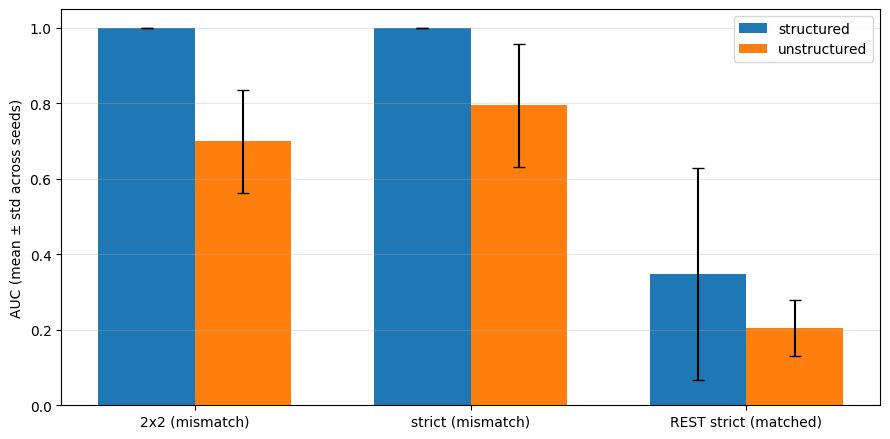

[OK] saved /content/fig_auc_summary.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Собираем mean±std по сценариям
plot_rows = []

for v in df_res["variant"].unique():
    sub = df_res[df_res["variant"] == v]
    plot_rows.append({"variant": v, "scenario": "2x2 (mismatch)", "mean": sub["AUC_2x2"].mean(), "std": sub["AUC_2x2"].std(ddof=1)})
    plot_rows.append({"variant": v, "scenario": "strict (mismatch)", "mean": sub["AUC_strict"].mean(), "std": sub["AUC_strict"].std(ddof=1)})

for v in df_rest["variant"].unique():
    sub = df_rest[df_rest["variant"] == v]
    plot_rows.append({"variant": v, "scenario": "REST strict (matched)", "mean": sub["AUC"].mean(), "std": sub["AUC"].std(ddof=1)})

df_plot = pd.DataFrame(plot_rows)
display(df_plot)

scenarios = ["2x2 (mismatch)", "strict (mismatch)", "REST strict (matched)"]
variants = sorted(df_plot["variant"].unique())

x = np.arange(len(scenarios))
width = 0.35 if len(variants) == 2 else 0.25

fig, ax = plt.subplots(figsize=(9, 4.5))

for i, v in enumerate(variants):
    d = df_plot[df_plot["variant"] == v].set_index("scenario").reindex(scenarios)
    means = d["mean"].values
    stds = d["std"].fillna(0.0).values
    ax.bar(x + (i - (len(variants)-1)/2)*width, means, width, yerr=stds, capsize=4, label=v)

ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=0)
ax.set_ylabel("AUC (mean ± std across seeds)")
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(axis="y", alpha=0.3)

out_path = "/content/fig_auc_summary.png"
plt.tight_layout()
plt.savefig(out_path, dpi=200)
plt.show()

print("[OK] saved", out_path)

#Autoencoder

In [ ]:
!pip -q install awscli nibabel pandas numpy scikit-learn tqdm

import os, re, glob, subprocess
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# sanity
!aws --version

aws-cli/1.44.11 Python/3.12.12 Linux/6.6.105+ botocore/1.42.21


In [ ]:
DATA_ROOT = "/content/openneuro_s3"

DS_TRAIN_NORMAL = "ds003688"   # source normal (train)
DS_EXT_NORMAL   = "ds001769"   # external normal (Forrest Gump)
DS_EXT_ANOM1    = "ds003999"   # stroke
DS_EXT_ANOM2    = "ds004884"   # aphasia
DS_REST_NORMAL  = "ds001168"   # rest-control normal

USE_SECOND_ANOMALY_DS = True

# сколько субъектов тянуть (как у тебя в rebuttal)
MAX_SUBJECTS = {
    DS_TRAIN_NORMAL: 30,
    DS_EXT_NORMAL:   15,  # phantom потом выкинем
    DS_EXT_ANOM1:    15,
    DS_EXT_ANOM2:    15,
    DS_REST_NORMAL:  15,
}

# метки для будущих df
LABELS = {
    DS_TRAIN_NORMAL: 0,
    DS_EXT_NORMAL:   0,
    DS_REST_NORMAL:  0,
    DS_EXT_ANOM1:    1,
    DS_EXT_ANOM2:    1,
}

os.makedirs(DATA_ROOT, exist_ok=True)

In [ ]:
def _run(cmd: str):
    print(cmd)
    subprocess.check_call(cmd, shell=True)

def aws_sync_meta(ds_id: str, out_dir: str):
    os.makedirs(out_dir, exist_ok=True)
    cmd = f'''
    aws s3 sync --no-sign-request "s3://openneuro.org/{ds_id}" "{out_dir}" \
      --exclude "*" \
      --include "dataset_description.json" \
      --include "participants.tsv"
    '''
    _run(cmd)

def read_subjects_from_participants(out_dir: str):
    p = os.path.join(out_dir, "participants.tsv")
    if not os.path.exists(p):
        return None
    try:
        dfp = pd.read_csv(p, sep="\t")
        col = "participant_id" if "participant_id" in dfp.columns else dfp.columns[0]
        subs = dfp[col].astype(str).tolist()
        subs = [s if s.startswith("sub-") else f"sub-{s}" for s in subs]
        subs = sorted(list(dict.fromkeys(subs)))
        return subs
    except Exception:
        return None

def list_subjects_via_s3(ds_id: str):
    cmd = f'aws s3 ls --no-sign-request "s3://openneuro.org/{ds_id}/"'
    out = subprocess.check_output(cmd, shell=True, text=True)
    subs = []
    for line in out.splitlines():
        m = re.search(r"PRE (sub-[^/]+)/", line)
        if m:
            subs.append(m.group(1))
    subs = sorted(list(dict.fromkeys(subs)))
    return subs if subs else None

def aws_sync_subject_bold(ds_id: str, subject: str, out_dir: str):
    subj_dir = os.path.join(out_dir, subject)
    os.makedirs(subj_dir, exist_ok=True)

    cmd = f'''
    aws s3 sync --no-sign-request "s3://openneuro.org/{ds_id}/{subject}" "{subj_dir}" \
      --exclude "*" \
      --include "func/*_bold.nii.gz" \
      --include "ses-*/func/*_bold.nii.gz" \
      --include "func/*_bold.nii" \
      --include "ses-*/func/*_bold.nii"
    '''
    _run(cmd)

def download_dataset_subset(ds_id: str, root: str, max_subjects=None, seed=0):
    out_dir = os.path.join(root, ds_id)
    os.makedirs(out_dir, exist_ok=True)

    print(f"\n=== {ds_id}: download meta ===")
    aws_sync_meta(ds_id, out_dir)

    subs = read_subjects_from_participants(out_dir)
    if subs is None:
        subs = list_subjects_via_s3(ds_id)
    if subs is None:
        raise RuntimeError(f"Cannot enumerate subjects for {ds_id}")

    # исключаем phantom ДО выбора max_subjects
    if ds_id == "ds001769":
        subs = [s for s in subs if s != "sub-phantom"]

    rng = np.random.default_rng(seed)
    if max_subjects is not None and len(subs) > max_subjects:
        subs = rng.choice(np.array(subs), size=max_subjects, replace=False).tolist()
        subs = sorted(subs)

    print(f"{ds_id}: selected subjects = {len(subs)} (max_subjects={max_subjects})")

    for i, s in enumerate(subs, 1):
        print(f"  [{i}/{len(subs)}] sync {s}")
        aws_sync_subject_bold(ds_id, s, out_dir)

    return out_dir

# ===== download all required datasets =====
paths = {}
seed_for_download = 0

datasets = [
    DS_TRAIN_NORMAL,
    DS_EXT_NORMAL,
    DS_EXT_ANOM1,
    DS_REST_NORMAL,
] + ([DS_EXT_ANOM2] if USE_SECOND_ANOMALY_DS else [])

for ds in datasets:
    paths[ds] = download_dataset_subset(
        ds_id=ds,
        root=DATA_ROOT,
        max_subjects=MAX_SUBJECTS.get(ds, None),
        seed=seed_for_download
    )

print("\nDownloaded roots:")
for k,v in paths.items():
    print(k, "->", v)


=== ds003688: download meta ===

    aws s3 sync --no-sign-request "s3://openneuro.org/ds003688" "/content/openneuro_s3/ds003688"       --exclude "*"       --include "dataset_description.json"       --include "participants.tsv"
    
ds003688: selected subjects = 30 (max_subjects=30)
  [1/30] sync sub-01

    aws s3 sync --no-sign-request "s3://openneuro.org/ds003688/sub-01" "/content/openneuro_s3/ds003688/sub-01"       --exclude "*"       --include "func/*_bold.nii.gz"       --include "ses-*/func/*_bold.nii.gz"       --include "func/*_bold.nii"       --include "ses-*/func/*_bold.nii"
    
  [2/30] sync sub-02

    aws s3 sync --no-sign-request "s3://openneuro.org/ds003688/sub-02" "/content/openneuro_s3/ds003688/sub-02"       --exclude "*"       --include "func/*_bold.nii.gz"       --include "ses-*/func/*_bold.nii.gz"       --include "func/*_bold.nii"       --include "ses-*/func/*_bold.nii"
    
  [3/30] sync sub-03

    aws s3 sync --no-sign-request "s3://openneuro.org/ds003688/sub-03

In [ ]:
def parse_entities_from_fname(path: str):
    base = os.path.basename(path)
    def m(pat, s, grp=1):
        mm = re.search(pat, s)
        return mm.group(grp) if mm else None

    sub  = m(r"(sub-[^_/]+)", path)
    ses  = m(r"(ses-[^_/]+)", path)
    task = m(r"task-([^_]+)", base)
    run  = m(r"run-([0-9]+)", base)
    return sub, ses, task, run

def index_local_bolds(ds_id: str, ds_root: str) -> pd.DataFrame:
    patt = os.path.join(ds_root, "sub-*", "**", "func", "*_bold.nii*")
    files = glob.glob(patt, recursive=True)
    rows = []
    for p in files:
        sub, ses, task, run = parse_entities_from_fname(p)
        if sub is None:
            continue
        rows.append(dict(dataset=ds_id, path=p, sub=sub, ses=ses, task=task, run=run))
    df = pd.DataFrame(rows).drop_duplicates()
    if len(df) == 0:
        raise RuntimeError(f"No local bold files indexed for {ds_id} in {ds_root}")
    return df

def pick_one_file_per_subject(df: pd.DataFrame, prefer_task: str | None = None, prefer_run: int = 1) -> pd.DataFrame:
    d = df.copy()
    d["run_num"] = pd.to_numeric(d["run"], errors="coerce").fillna(999).astype(int)
    d["task_match"] = 0 if prefer_task is None else (d["task"] == prefer_task).astype(int)
    d["run_match"] = (d["run_num"] == int(prefer_run)).astype(int)
    d["path_len"] = d["path"].str.len()

    d = d.sort_values(["sub","task_match","run_match","run_num","path_len"],
                      ascending=[True, False, False, True, True])
    one = d.groupby("sub", as_index=False).head(1).copy()
    return one.drop(columns=["run_num","task_match","run_match","path_len"], errors="ignore")

# какие task предпочитаем (чтобы REST-контроль был честный)
PREFER_TASK = {
    DS_EXT_ANOM1: "rest",     # ds003999: предпочесть rest
    DS_REST_NORMAL: "rest",   # ds001168: rest
    # остальные можно None
}

dfs = {}
for ds_id in datasets:
    ds_root = paths[ds_id]
    df_idx = index_local_bolds(ds_id, ds_root)

    # phantom уже исключали на этапе выбора субъектов, но на всякий случай:
    if ds_id == "ds001769":
        df_idx = df_idx[df_idx["sub"] != "sub-phantom"].copy()

    one = pick_one_file_per_subject(df_idx, prefer_task=PREFER_TASK.get(ds_id, None), prefer_run=1)
    one["label"] = LABELS[ds_id]
    dfs[ds_id] = one.reset_index(drop=True)

print("Subjects(one-file-per-subject):")
for k,v in dfs.items():
    print(k, "subjects:", v["sub"].nunique(), "files:", len(v))

# проверка task-состава (важно для rebuttal)
print("\nTask breakdown:")
for k,v in dfs.items():
    if "task" in v.columns:
        print(k)
        print(v.groupby(["task"]).size())

Subjects(one-file-per-subject):
ds003688 subjects: 13 files: 13
ds001769 subjects: 15 files: 15
ds003999 subjects: 15 files: 15
ds001168 subjects: 15 files: 15
ds004884 subjects: 10 files: 10

Task breakdown:
ds003688
task
film    13
dtype: int64
ds001769
task
movie    15
dtype: int64
ds003999
task
rest    15
dtype: int64
ds001168
task
rest    15
dtype: int64
ds004884
task
naming40    8
rest        2
dtype: int64


In [ ]:
# source split
df_source_all = dfs[DS_TRAIN_NORMAL].copy()

train_subs, val_subs = train_test_split(
    df_source_all["sub"].unique(),
    test_size=0.2,
    random_state=123,
    shuffle=True
)

df_source_train = df_source_all[df_source_all["sub"].isin(set(train_subs))].copy()
df_source_val   = df_source_all[df_source_all["sub"].isin(set(val_subs))].copy()

print("source train subjects:", df_source_train["sub"].nunique(), "files:", len(df_source_train))
print("source val   subjects:", df_source_val["sub"].nunique(), "files:", len(df_source_val))

df_688  = dfs[DS_TRAIN_NORMAL].copy()
df_769  = dfs[DS_EXT_NORMAL].copy()
df_3999 = dfs[DS_EXT_ANOM1].copy()
df_4884 = dfs[DS_EXT_ANOM2].copy() if USE_SECOND_ANOMALY_DS else None
df_1168 = dfs[DS_REST_NORMAL].copy()

n_per_ds = min(
    len(df_688), len(df_769), len(df_3999),
    len(df_4884) if df_4884 is not None else 10
)
n_per_ds = min(n_per_ds, 15)  # как в статье
print("Using n_per_ds for eval =", n_per_ds)

def take_n(df, n, seed=0):
    if len(df) <= n:
        return df.copy()
    return df.sample(n=n, random_state=seed).copy()

# 2x2 mismatch
parts = [
    take_n(df_769,  n_per_ds, seed=1),
    take_n(df_688,  n_per_ds, seed=2),
    take_n(df_3999, n_per_ds, seed=3),
]
if df_4884 is not None:
    parts.append(take_n(df_4884, n_per_ds, seed=4))

df_eval_2x2 = pd.concat(parts, ignore_index=True)

# strict: external normal vs external anomalies
parts = [
    take_n(df_769,  n_per_ds, seed=5),
    take_n(df_3999, n_per_ds, seed=6),
]
if df_4884 is not None:
    parts.append(take_n(df_4884, n_per_ds, seed=7))

df_eval_strict = pd.concat(parts, ignore_index=True)

# REST control: ds001168(rest, normal) vs ds003999(rest, anomaly)
def only_rest(df):
    d = df.copy()
    if "task" in d.columns:
        d = d[d["task"].fillna("").str.lower() == "rest"]
    return d

df_1168_rest = only_rest(dfs[DS_REST_NORMAL].copy())
df_3999_rest = only_rest(dfs[DS_EXT_ANOM1].copy())

n_rest = min(len(df_1168_rest), len(df_3999_rest), 15)
print("Using n_rest =", n_rest)

df_rest = pd.concat([
    take_n(df_1168_rest, n_rest, seed=8),
    take_n(df_3999_rest, n_rest, seed=9),
], ignore_index=True)

print("\nEval 2x2 breakdown:")
print(df_eval_2x2.groupby(["dataset","label"]).size())
print("\nEval strict breakdown:")
print(df_eval_strict.groupby(["dataset","label"]).size())
print("\nREST breakdown:")
print(df_rest.groupby(["dataset","label"]).size())

source train subjects: 10 files: 10
source val   subjects: 3 files: 3
Using n_per_ds for eval = 10
Using n_rest = 15

Eval 2x2 breakdown:
dataset   label
ds001769  0        10
ds003688  0        10
ds003999  1        10
ds004884  1        10
dtype: int64

Eval strict breakdown:
dataset   label
ds001769  0        10
ds003999  1        10
ds004884  1        10
dtype: int64

REST breakdown:
dataset   label
ds001168  0        15
ds003999  1        15
dtype: int64


In [ ]:
for v in ["df_source_train","df_source_val","df_eval_2x2","df_eval_strict","df_rest"]:
    print(v, "OK" if v in globals() else "MISSING")

df_source_train OK
df_source_val OK
df_eval_2x2 OK
df_eval_strict OK
df_rest OK


In [ ]:
# =========================
# Autoencoder baseline: train + eval in your rebuttal protocol
# =========================

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score

# Если nibabel не установлен:
# !pip -q install nibabel
import nibabel as nib

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Helpers: find path + label
# -------------------------
def _get_paths(df: pd.DataFrame) -> np.ndarray:
    for c in ["path","bold_path","nii_path","filepath","file","fname"]:
        if c in df.columns:
            return df[c].astype(str).values
    # fallback: index
    idx = df.index.astype(str)
    if np.any([(".nii" in s) for s in idx]):
        return idx.values
    raise ValueError(f"Cannot infer file paths from df. Columns={list(df.columns)}; index sample={df.index[:3]}")

def _get_labels(df: pd.DataFrame) -> np.ndarray:
    for c in ["label","y","target","cls"]:
        if c in df.columns:
            return df[c].astype(int).values
    raise ValueError(f"Cannot infer labels from df. Columns={list(df.columns)}")

# -------------------------
# Preprocessing (match your text: 2D mean over slices, resize 64x64, normalize to [0,1], T=5)
# -------------------------
def load_fmri_seq_2dmean(path: str, seq_len: int = 5, out_hw: int = 64, seed: int = 0) -> torch.Tensor:
    """
    Returns tensor shape [1, T, H, W] float32 in [0,1].
    Deterministic random start given seed+path.
    """
    img = nib.load(path)
    x = img.get_fdata()  # typically [X,Y,Z,T]
    if x.ndim != 4:
        raise ValueError(f"Expected 4D NIfTI, got shape={x.shape} for {path}")

    # mean over slices (Z)
    x2 = x.mean(axis=2)  # [X,Y,T]
    T = x2.shape[-1]
    if T < seq_len:
        # pad by repeating last frame
        pad = seq_len - T
        last = x2[..., -1:]
        x2 = np.concatenate([x2, np.repeat(last, pad, axis=-1)], axis=-1)
        T = x2.shape[-1]

    # deterministic start
    rs = np.random.RandomState((abs(hash(path)) + 10_000 * seed) % (2**32 - 1))
    start = int(rs.randint(0, T - seq_len + 1))
    seq = x2[..., start:start+seq_len]  # [X,Y,T]

    # normalize to [0,1] per-sequence (robust enough for baseline)
    mn = np.min(seq)
    mx = np.max(seq)
    if mx > mn:
        seq = (seq - mn) / (mx - mn)
    else:
        seq = np.zeros_like(seq)

    # to torch, resize each frame
    # current shape [X,Y,T] -> [T,1,X,Y]
    seq_t = torch.from_numpy(np.transpose(seq, (2,0,1))).unsqueeze(1).float()  # [T,1,X,Y]
    seq_t = F.interpolate(seq_t, size=(out_hw, out_hw), mode="bilinear", align_corners=False)  # [T,1,64,64]
    # [T,1,H,W] -> [1,T,H,W]
    seq_t = seq_t.squeeze(1).unsqueeze(0)  # [1,T,H,W]
    return seq_t.clamp(0,1)

# -------------------------
# Dataset
# -------------------------
class SubjectSeqDataset(Dataset):
    def __init__(self, df: pd.DataFrame, seq_len: int, out_hw: int, seed: int, labeled: bool):
        self.df = df.reset_index(drop=False).copy()
        self.paths = _get_paths(df)
        self.labeled = labeled
        self.labels = _get_labels(df) if labeled else None
        self.seq_len = seq_len
        self.out_hw = out_hw
        self.seed = seed

    def __len__(self): return len(self.paths)

    def __getitem__(self, i):
        x = load_fmri_seq_2dmean(self.paths[i], seq_len=self.seq_len, out_hw=self.out_hw, seed=self.seed)
        if self.labeled:
            y = int(self.labels[i])
            return x, y
        return x

def make_loader(df, seed, labeled, batch_size=8, shuffle=False, seq_len=5, out_hw=64):
    ds = SubjectSeqDataset(df, seq_len=seq_len, out_hw=out_hw, seed=seed, labeled=labeled)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)

# -------------------------
# Simple 3D Conv Autoencoder (if you insist on ConvLSTM AE, swap this class to your ConvLSTM Autoencoder)
# Input: [B, 1, T, H, W]
# -------------------------
class Conv3DAE(nn.Module):
    def __init__(self, ch=16):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv3d(1, ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1,2,2)),
            nn.Conv3d(ch, 2*ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1,2,2)),
            nn.Conv3d(2*ch, 4*ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1,2,2)),
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose3d(4*ch, 2*ch, kernel_size=(1,2,2), stride=(1,2,2)),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(2*ch, ch, kernel_size=(1,2,2), stride=(1,2,2)),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(ch, ch, kernel_size=(1,2,2), stride=(1,2,2)),
            nn.ReLU(inplace=True),
            nn.Conv3d(ch, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.enc(x)
        out = self.dec(z)
        return out

# -------------------------
# Train AE on NORMAL only
# -------------------------
def train_ae(ae, train_loader, val_loader, lr=1e-3, max_epochs=50, patience=5):
    ae = ae.to(DEVICE)
    opt = torch.optim.Adam(ae.parameters(), lr=lr)
    crit = nn.MSELoss()

    best = None
    best_val = float("inf")
    bad = 0

    for ep in range(1, max_epochs+1):
        ae.train()
        tr_loss = 0.0
        n = 0
        for xb in train_loader:
            xb = xb.to(DEVICE)  # [B,1,T,H,W]
            opt.zero_grad()
            recon = ae(xb)
            loss = crit(recon, xb)
            loss.backward()
            opt.step()
            tr_loss += loss.item() * xb.size(0)
            n += xb.size(0)
        tr_loss /= max(n,1)

        ae.eval()
        va_loss = 0.0
        n = 0
        with torch.no_grad():
            for xb in val_loader:
                xb = xb.to(DEVICE)
                recon = ae(xb)
                loss = crit(recon, xb)
                va_loss += loss.item() * xb.size(0)
                n += xb.size(0)
        va_loss /= max(n,1)

        print(f"[AE] epoch {ep}: train_rec_loss={tr_loss:.6f} val_rec_loss={va_loss:.6f}")

        if va_loss < best_val - 1e-6:
            best_val = va_loss
            best = {k:v.detach().cpu().clone() for k,v in ae.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best is not None:
        ae.load_state_dict(best)
    return ae

# -------------------------
# Scoring: reconstruction MSE per subject
# -------------------------
@torch.no_grad()
def ae_scores(ae, loader_labeled):
    ae.eval()
    ys, scores = [], []
    for xb, yb in loader_labeled:
        xb = xb.to(DEVICE)
        recon = ae(xb)
        err = ((recon - xb)**2).mean(dim=[1,2,3,4]).detach().cpu().numpy()
        scores.extend(err.tolist())
        ys.extend(list(yb))
    return np.array(ys, dtype=int), np.array(scores, dtype=float)

def youden_threshold(y, score):
    fpr, tpr, thr = roc_curve(y, score)
    j = tpr - fpr
    k = int(np.nanargmax(j))
    return float(thr[k])

def bootstrap_auc_ci(y, score, n_boot=500, seed=0):
    rs = np.random.RandomState(seed)
    aucs = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        s = rs.choice(idx, size=len(idx), replace=True)
        yy = y[s]
        if len(np.unique(yy)) < 2:
            continue
        aucs.append(roc_auc_score(yy, score[s]))
    if len(aucs)==0:
        return float("nan"), (float("nan"), float("nan"))
    aucs = np.array(aucs)
    med = float(np.median(aucs))
    ci = (float(np.quantile(aucs, 0.025)), float(np.quantile(aucs, 0.975)))
    return med, ci

def calibrated_eval_ae(ae, df_all, seed, cal_frac=0.25, n_boot=500, batch_size=8):
    """
    Calibration on a subset of subjects from df_all; evaluation on the rest.
    Assumes df_all has label column.
    """
    # split deterministically by seed
    df = df_all.copy()
    rs = np.random.RandomState(seed)
    perm = rs.permutation(len(df))
    n_cal = max(1, int(round(cal_frac * len(df))))
    cal_idx = perm[:n_cal]
    tst_idx = perm[n_cal:]
    df_cal = df.iloc[cal_idx].copy()
    df_tst = df.iloc[tst_idx].copy()

    cal_loader = make_loader(df_cal, seed=seed, labeled=True, batch_size=batch_size, shuffle=False)
    tst_loader = make_loader(df_tst, seed=seed, labeled=True, batch_size=batch_size, shuffle=False)

    y_cal, s_cal = ae_scores(ae, cal_loader)
    y_tst, s_tst = ae_scores(ae, tst_loader)

    auc = float(roc_auc_score(y_tst, s_tst)) if len(np.unique(y_tst))==2 else float("nan")
    thr = youden_threshold(y_cal, s_cal) if len(np.unique(y_cal))==2 else float(np.quantile(s_cal, 0.95))
    yhat = (s_tst >= thr).astype(int)

    acc = float(accuracy_score(y_tst, yhat))
    f1  = float(f1_score(y_tst, yhat))

    med, ci = bootstrap_auc_ci(y_tst, s_tst, n_boot=n_boot, seed=seed+123)

    cm = confusion_matrix(y_tst, yhat, labels=[0,1])
    cm_df = pd.DataFrame(cm, index=["True:Normal","True:Anomaly"], columns=["Pred:Normal","Pred:Anomaly"])

    metrics = dict(
        AUC=auc, ACC=acc, F1=f1, thr=thr,
        AUC_subject_median=med, AUC_subject_CI95=ci,
        n_test_subjects=int(len(df_tst))
    )
    return metrics, cm_df

def external_normal_fpr(ae, df_source_val_norm, df_external_norm, seed, q=0.95, batch_size=8):
    """
    Threshold from source-val normals (q-quantile of recon error).
    Then FPR on external normals.
    """
    src_loader = make_loader(df_source_val_norm, seed=seed, labeled=True, batch_size=batch_size, shuffle=False)
    ext_loader = make_loader(df_external_norm, seed=seed, labeled=True, batch_size=batch_size, shuffle=False)

    y_src, s_src = ae_scores(ae, src_loader)
    # y_src expected all 0
    thr = float(np.quantile(s_src, q))
    y_ext, s_ext = ae_scores(ae, ext_loader)
    # y_ext expected all 0
    fpr = float(np.mean(s_ext >= thr))
    return fpr, thr

# =========================
# RUN: YOU MUST HAVE THESE DATAFRAMES ALREADY CREATED IN YOUR NOTEBOOK:
# df_source_train (normals only, ds003688 train split)
# df_source_val   (normals only, ds003688 val split)
# df_eval_2x2, df_eval_strict, df_rest
# and you need df_norm_ext = subset of df_eval_* that corresponds to ds001769 normals only
# =========================

SEEDS = [42, 43, 44]
SEQ_LEN = 5
BS = 8
N_BOOT = 500

# IMPORTANT: build external normals df (ds001769 only) from your eval pool.
# If your df has 'dataset' column:
def pick_ds001769_norm(df):
    d = df.copy()
    if "dataset" in d.columns:
        d = d[(d["dataset"]=="ds001769")]
    # keep only normals:
    if "label" in d.columns:
        d = d[d["label"]==0]
    return d

df_ext_norm = pick_ds001769_norm(df_eval_2x2)  # ds001769 normals from eval pool

rows = []
for seed in SEEDS:
    print("\n"+"="*30)
    print(f"[AE BASELINE] SEED={seed}")
    print("="*30)

    # loaders for AE training: NORMAL only (unlabeled)
    tr_unsup = make_loader(df_source_train, seed=seed, labeled=False, batch_size=BS, shuffle=True, seq_len=SEQ_LEN)
    va_unsup = make_loader(df_source_val,   seed=seed, labeled=False, batch_size=BS, shuffle=False, seq_len=SEQ_LEN)

    ae = Conv3DAE(ch=16)
    ae = train_ae(ae, tr_unsup, va_unsup, lr=1e-3, max_epochs=50, patience=5)

    # external-normal FPR with threshold from source-val normals
    # For this, we need labeled loaders, so we pass df_source_val with label=0.
    # If df_source_val currently lacks labels, create a temp view:
    if "label" not in df_source_val.columns:
        df_source_val_l = df_source_val.copy()
        df_source_val_l["label"] = 0
    else:
        df_source_val_l = df_source_val.copy()

    if "label" not in df_ext_norm.columns:
        df_ext_norm_l = df_ext_norm.copy()
        df_ext_norm_l["label"] = 0
    else:
        df_ext_norm_l = df_ext_norm.copy()

    fpr_ext, thr_src = external_normal_fpr(ae, df_source_val_l, df_ext_norm_l, seed=seed, q=0.95, batch_size=BS)
    print(f"[AE] external-normal FPR (ds001769) @thr(q95 source-val) = {fpr_ext:.3f} (thr={thr_src:.6f})")

    # EVALs with your calibrated protocol (simple cal_frac split; if you want per-(dataset,label) stratified, say so and I’ll give exact code)
    m2x2, cm2x2 = calibrated_eval_ae(ae, df_eval_2x2, seed=seed, cal_frac=0.25, n_boot=N_BOOT, batch_size=BS)
    print("[AE] EVAL 2x2:", m2x2)
    print(cm2x2)

    mstrict, cmstrict = calibrated_eval_ae(ae, df_eval_strict, seed=seed, cal_frac=0.25, n_boot=N_BOOT, batch_size=BS)
    print("[AE] EVAL strict:", mstrict)
    print(cmstrict)

    mrest, cmrest = calibrated_eval_ae(ae, df_rest, seed=seed, cal_frac=0.25, n_boot=N_BOOT, batch_size=BS)
    print("[AE] EVAL REST:", mrest)
    print(cmrest)

    rows.append(dict(
        seed=seed, variant="autoencoder",
        val_auc_source=np.nan,          # not defined for AE without labeled source-val
        extnorm_FPR=fpr_ext,
        thr_sourceval=thr_src,

        AUC_2x2=m2x2["AUC"], F1_2x2=m2x2["F1"], ACC_2x2=m2x2["ACC"],
        AUCsub_med_2x2=m2x2["AUC_subject_median"], AUCsub_CI95_2x2=str(m2x2["AUC_subject_CI95"]),

        AUC_strict=mstrict["AUC"], F1_strict=mstrict["F1"], ACC_strict=mstrict["ACC"],
        AUCsub_med_strict=mstrict["AUC_subject_median"], AUCsub_CI95_strict=str(mstrict["AUC_subject_CI95"]),

        AUC_rest=mrest["AUC"], F1_rest=mrest["F1"], ACC_rest=mrest["ACC"]
    ))

df_ae = pd.DataFrame(rows)
display(df_ae)

out_path = "/content/ae_baseline_results.csv"
df_ae.to_csv(out_path, index=False)
print("Saved:", out_path)

# Если хочешь склеить с твоим rebuttal_results.csv:
# df_prev = pd.read_csv("/content/rebuttal_results.csv")
# df_all = pd.concat([df_prev, df_ae], ignore_index=True)
# df_all.to_csv("/content/rebuttal_results_with_ae.csv", index=False)


[AE BASELINE] SEED=42
[AE] epoch 1: train_rec_loss=0.152353 val_rec_loss=0.149707
[AE] epoch 2: train_rec_loss=0.146793 val_rec_loss=0.144333
[AE] epoch 3: train_rec_loss=0.141387 val_rec_loss=0.138966
[AE] epoch 4: train_rec_loss=0.135854 val_rec_loss=0.133427
[AE] epoch 5: train_rec_loss=0.130236 val_rec_loss=0.127497
[AE] epoch 6: train_rec_loss=0.124164 val_rec_loss=0.120693
[AE] epoch 7: train_rec_loss=0.117073 val_rec_loss=0.112362
[AE] epoch 8: train_rec_loss=0.108355 val_rec_loss=0.102111
[AE] epoch 9: train_rec_loss=0.097545 val_rec_loss=0.089840
[AE] epoch 10: train_rec_loss=0.084697 val_rec_loss=0.077277
[AE] epoch 11: train_rec_loss=0.071943 val_rec_loss=0.068299
[AE] epoch 12: train_rec_loss=0.063285 val_rec_loss=0.062857
[AE] epoch 13: train_rec_loss=0.058198 val_rec_loss=0.054168
[AE] epoch 14: train_rec_loss=0.049506 val_rec_loss=0.041923
[AE] epoch 15: train_rec_loss=0.038318 val_rec_loss=0.034573
[AE] epoch 16: train_rec_loss=0.031701 val_rec_loss=0.031920
[AE] epoch

EOFError: Caught EOFError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipython-input-1499322513.py", line 100, in __getitem__
    x = load_fmri_seq_2dmean(self.paths[i], seq_len=self.seq_len, out_hw=self.out_hw, seed=self.seed)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1499322513.py", line 49, in load_fmri_seq_2dmean
    x = img.get_fdata()  # typically [X,Y,Z,T]
        ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/nibabel/dataobj_images.py", line 374, in get_fdata
    data = np.asanyarray(self._dataobj, dtype=dtype)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/nibabel/arrayproxy.py", line 454, in __array__
    arr = self._get_scaled(dtype=dtype, slicer=())
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/nibabel/arrayproxy.py", line 421, in _get_scaled
    scaled = apply_read_scaling(self._get_unscaled(slicer=slicer), scl_slope, scl_inter)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/nibabel/arrayproxy.py", line 391, in _get_unscaled
    return array_from_file(
           ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/nibabel/volumeutils.py", line 467, in array_from_file
    n_read = infile.readinto(data_bytes)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/gzip.py", line 338, in read
    return self._buffer.read(size)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/_compression.py", line 68, in readinto
    data = self.read(len(byte_view))
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/gzip.py", line 564, in read
    raise EOFError("Compressed file ended before the "
EOFError: Compressed file ended before the end-of-stream marker was reached


In [ ]:
import gzip

def list_paths(df):
    # под ваш AE-код: он умеет брать path из колонок
    for c in ["path","bold_path","nii_path","filepath","file","fname"]:
        if c in df.columns:
            return df[c].astype(str).tolist()
    return df.index.astype(str).tolist()

def gzip_ok(p):
    if not p.endswith(".gz"):
        return True
    try:
        with gzip.open(p, "rb") as f:
            # читаем небольшой кусок + “дотянуться” до конца
            f.read(1024 * 1024)
            while f.read(1024 * 1024):
                pass
        return True
    except Exception:
        return False

def check_paths(name, paths):
    bad = []
    for p in paths:
        if not os.path.exists(p):
            bad.append((p, "missing"))
        elif p.endswith(".gz") and (not gzip_ok(p)):
            bad.append((p, "gzip_corrupt"))
    print(f"{name}: total={len(paths)} bad={len(bad)}")
    return bad

bad_all = []
bad_all += check_paths("df_eval_2x2", list_paths(df_eval_2x2))
bad_all += check_paths("df_eval_strict", list_paths(df_eval_strict))
bad_all += check_paths("df_rest", list_paths(df_rest))

# уникализируем
bad_all = list(dict.fromkeys(bad_all))

print("\nBAD FILES:")
for p, why in bad_all:
    print(why, ":", p)

df_eval_2x2: total=40 bad=1
df_eval_strict: total=30 bad=1
df_rest: total=30 bad=1

BAD FILES:
gzip_corrupt : /content/openneuro_s3/ds003999/sub-05/ses-pre/func/sub-05_ses-pre_task-rest_bold.nii.gz


In [ ]:
def to_s3_uri(local_path):
    # local_path выглядит как: /content/openneuro_s3/ds003999/sub-01/.../file_bold.nii.gz
    m = re.search(r"/(ds[0-9]+)/(.+)$", local_path)
    if not m:
        raise ValueError(f"Cannot map to s3 uri: {local_path}")
    ds_id = m.group(1)
    rel = m.group(2)
    return f"s3://openneuro.org/{ds_id}/{rel}"

def redownload_file(local_path):
    s3 = to_s3_uri(local_path)
    os.makedirs(os.path.dirname(local_path), exist_ok=True)
    if os.path.exists(local_path):
        os.remove(local_path)
    cmd = f'aws s3 cp --no-sign-request "{s3}" "{local_path}"'
    print(cmd)
    subprocess.check_call(cmd, shell=True)

# перекачать все плохие файлы
for p, why in bad_all:
    if why in ("gzip_corrupt", "missing"):
        redownload_file(p)

print("[OK] redownload complete")

aws s3 cp --no-sign-request "s3://openneuro.org/ds003999/sub-05/ses-pre/func/sub-05_ses-pre_task-rest_bold.nii.gz" "/content/openneuro_s3/ds003999/sub-05/ses-pre/func/sub-05_ses-pre_task-rest_bold.nii.gz"
[OK] redownload complete


In [ ]:
import gzip

def list_paths(df):
    # под ваш AE-код: он умеет брать path из колонок
    for c in ["path","bold_path","nii_path","filepath","file","fname"]:
        if c in df.columns:
            return df[c].astype(str).tolist()
    return df.index.astype(str).tolist()

def gzip_ok(p):
    if not p.endswith(".gz"):
        return True
    try:
        with gzip.open(p, "rb") as f:
            # читаем небольшой кусок + “дотянуться” до конца
            f.read(1024 * 1024)
            while f.read(1024 * 1024):
                pass
        return True
    except Exception:
        return False

def check_paths(name, paths):
    bad = []
    for p in paths:
        if not os.path.exists(p):
            bad.append((p, "missing"))
        elif p.endswith(".gz") and (not gzip_ok(p)):
            bad.append((p, "gzip_corrupt"))
    print(f"{name}: total={len(paths)} bad={len(bad)}")
    return bad

bad_all = []
bad_all += check_paths("df_eval_2x2", list_paths(df_eval_2x2))
bad_all += check_paths("df_eval_strict", list_paths(df_eval_strict))
bad_all += check_paths("df_rest", list_paths(df_rest))

# уникализируем
bad_all = list(dict.fromkeys(bad_all))

print("\nBAD FILES:")
for p, why in bad_all:
    print(why, ":", p)

df_eval_2x2: total=40 bad=1
df_eval_strict: total=30 bad=1
df_rest: total=30 bad=1

BAD FILES:
gzip_corrupt : /content/openneuro_s3/ds003999/sub-05/ses-pre/func/sub-05_ses-pre_task-rest_bold.nii.gz


In [ ]:
bad_path = "/content/openneuro_s3/ds003999/sub-05/ses-pre/func/sub-05_ses-pre_task-rest_bold.nii.gz"

def drop_bad(df):
    if "path" in df.columns:
        return df[df["path"] != bad_path].copy()
    return df[df.index.astype(str) != bad_path].copy()

# удаляем из всех, где может встречаться
df_eval_2x2    = drop_bad(df_eval_2x2)
df_eval_strict = drop_bad(df_eval_strict)
df_rest        = drop_bad(df_rest)

# также удалим из исходного пула ds003999, если он у вас есть (на всякий случай)
if "dfs" in globals() and "ds003999" in dfs:
    dfs["ds003999"] = drop_bad(dfs["ds003999"])

print("Dropped bad path. New counts:")
print("df_eval_2x2:", len(df_eval_2x2))
print("df_eval_strict:", len(df_eval_strict))
print("df_rest:", len(df_rest))

Dropped bad path. New counts:
df_eval_2x2: 39
df_eval_strict: 29
df_rest: 29


In [ ]:
# повтор eval после фикса файлов
m2x2, cm2x2 = calibrated_eval_ae(ae, df_eval_2x2, seed=42, cal_frac=0.25, n_boot=N_BOOT, batch_size=BS)
print("[AE] EVAL 2x2:", m2x2); print(cm2x2)

mstrict, cmstrict = calibrated_eval_ae(ae, df_eval_strict, seed=42, cal_frac=0.25, n_boot=N_BOOT, batch_size=BS)
print("[AE] EVAL strict:", mstrict); print(cmstrict)

mrest, cmrest = calibrated_eval_ae(ae, df_rest, seed=42, cal_frac=0.25, n_boot=N_BOOT, batch_size=BS)
print("[AE] EVAL REST:", mrest); print(cmrest)

[AE] EVAL 2x2: {'AUC': 0.5961538461538461, 'ACC': 0.6551724137931034, 'F1': 0.7222222222222222, 'thr': 0.009949286468327045, 'AUC_subject_median': 0.6000000000000001, 'AUC_subject_CI95': (0.3620343137254902, 0.7888574660633484), 'n_test_subjects': 29}
              Pred:Normal  Pred:Anomaly
True:Normal             6            10
True:Anomaly            0            13
[AE] EVAL strict: {'AUC': 0.20535714285714285, 'ACC': 0.36363636363636365, 'F1': 0.2222222222222222, 'thr': 0.02238849177956581, 'AUC_subject_median': 0.2, 'AUC_subject_CI95': (0.033333333333333326, 0.4179166666666666), 'n_test_subjects': 22}
              Pred:Normal  Pred:Anomaly
True:Normal             6             2
True:Anomaly           12             2
[AE] EVAL REST: {'AUC': 0.0, 'ACC': 0.3181818181818182, 'F1': 0.0, 'thr': 0.024609187617897987, 'AUC_subject_median': 0.0, 'AUC_subject_CI95': (0.0, 0.0), 'n_test_subjects': 22}
              Pred:Normal  Pred:Anomaly
True:Normal             7             5
True:An